In [66]:
%load_ext autoreload
%autoreload 2

import helper
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Cropping2D, Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dropout, Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as k
from keras.initializers import TruncatedNormal
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import h5py
import pdb
from sklearn.utils import class_weight

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in data, format, & visualize

In [2]:
emotion_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
image_shape = (48,48,1)
n_classes = len(emotion_dict)
n_features = np.product(image_shape)

In [3]:
# read in data
file_path = './data/Kaggle-FER/fer2013.csv'
data_raw = helper.read_in_data(file_path) # data is a tuple of (x_list, y_list, usage_list)

In [4]:
# remove blanks, over sample, convert data to numpy array
data_formatted = helper.format(data_raw, image_shape, n_classes) # return tuple of (x_array, y_array, usage_list)

In [61]:
# number of example for each class
label, count = np.unique(data_formatted[1], return_counts=True)
dict(zip(label, count))

{0: 4945, 1: 547, 2: 5121, 3: 8988, 4: 6076, 5: 4001, 6: 6197}

In [64]:
# split into train & test sets. Test set = public, private set is used for final testing, to be consistent with the competition
(x_train, y_train), (x_test, y_test), (x_private, y_private) = helper.create_train_test(data_formatted, n_classes)

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}


In [67]:
# class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train.reshape(-1)), y_train.reshape(-1))
class_weight = dict(enumerate(class_weight))
print(class_weight)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


# Build model & train

# 1st place model

## featurewise, flip, seed=0

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/500
112/112 [==============================] - 4s - loss: 1.7060 - acc: 0.3167 - val_loss: 1.5684 - val_acc: 0.3881
Epoch 2/500
112/112 [==============================] - 4s - loss: 1.5392 - acc: 0.4053 - val_loss: 1.4573 - val_acc: 0.4361
Epoch 3/500
112/112 [==============================] - 4s - loss: 1.4363 - acc: 0.4464 - val_loss: 1.3958 - val_acc: 0.4637
Epoch 4/500
112/112 [==============================] - 4s - loss: 1.3623 - acc: 0.4761 - val_loss: 1.3087 - val_acc: 0.4940
Epoch 5/500
112/112 [==============================] - 3s - loss: 1.2945 - acc: 0.5068 - val_loss: 1.2681 - val_acc: 0.5210
Epoch 6/500
112/112 [==============================] - 4s - loss: 1.2481 - acc: 0.5281 - val_loss: 1.2568 - val_acc: 0.5267
Epoch 7/500
112/112 [==============================] - 3s - loss: 1.1998 - acc: 0.5463 - val_loss: 1.2306 - val_acc: 0.5312
Epoch 8/500
112/112 [==============================] - 3s - loss: 1.1593 - acc: 0.5620 - val_loss: 1.2045 -

112/112 [==============================] - 3s - loss: 0.2753 - acc: 0.9035 - val_loss: 1.5774 - val_acc: 0.5780
Epoch 32/500
112/112 [==============================] - 3s - loss: 0.2689 - acc: 0.9061 - val_loss: 1.5594 - val_acc: 0.5912
Epoch 33/500
112/112 [==============================] - 3s - loss: 0.2533 - acc: 0.9134 - val_loss: 1.5577 - val_acc: 0.5864
Epoch 34/500
112/112 [==============================] - 3s - loss: 0.2433 - acc: 0.9149 - val_loss: 1.5624 - val_acc: 0.5912
Epoch 35/500
112/112 [==============================] - 3s - loss: 0.2343 - acc: 0.9175 - val_loss: 1.5928 - val_acc: 0.5840
Epoch 36/500
110/112 [============================>.] - ETA: 0s - loss: 0.2278 - acc: 0.9220Epoch 00035: val_loss did not improve

Epoch 00035: reducing learning rate to 0.0031250000465661287.
112/112 [==============================] - 3s - loss: 0.2273 - acc: 0.9221 - val_loss: 1.5936 - val_acc: 0.5873
Epoch 37/500
112/112 [==============================] - 3s - loss: 0.2169 - acc: 0.

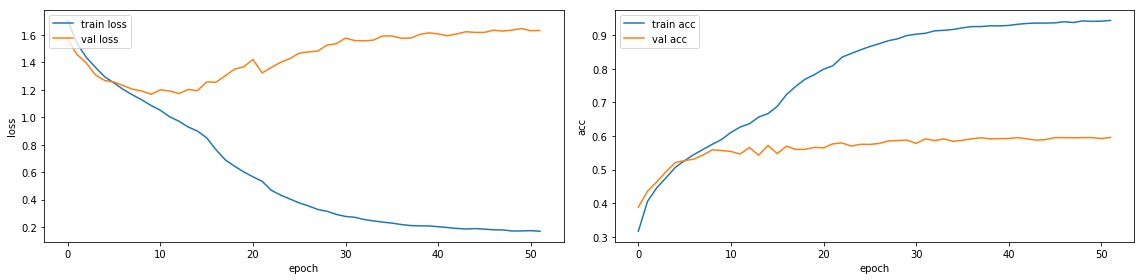

In [11]:
cp_name = './models/1st place/featurewise_flip_seed0.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=1))

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, seed=1

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/500
112/112 [==============================] - 4s - loss: 1.7110 - acc: 0.3108 - val_loss: 1.5542 - val_acc: 0.3993
Epoch 2/500
112/112 [==============================] - 4s - loss: 1.5076 - acc: 0.4189 - val_loss: 1.4126 - val_acc: 0.4637
Epoch 3/500
112/112 [==============================] - 3s - loss: 1.4080 - acc: 0.4604 - val_loss: 1.3464 - val_acc: 0.4847
Epoch 4/500
112/112 [==============================] - 4s - loss: 1.3179 - acc: 0.4982 - val_loss: 1.2688 - val_acc: 0.5189
Epoch 5/500
112/112 [==============================] - 3s - loss: 1.2583 - acc: 0.5221 - val_loss: 1.2222 - val_acc: 0.5288
Epoch 6/500
112/112 [==============================] - 3s - loss: 1.2072 - acc: 0.5439 - val_loss: 1.2122 - val_acc: 0.5330
Epoch 7/500
112/112 [==============================] - 4s - loss: 1.1749 - acc: 0.5547 - val_loss: 1.1786 - val_acc: 0.5540
Epoch 8/500
112/112 [==============================] - 3s - loss: 1.1246 - acc: 0.5784 - val_loss: 1.1927 -

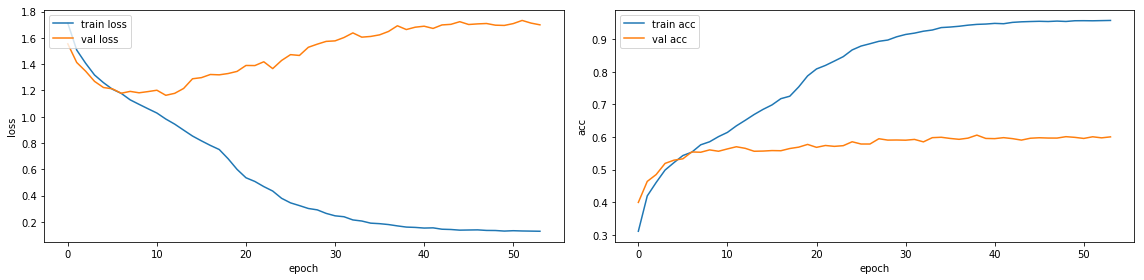

In [12]:
cp_name = './models/1st place/featurewise_flip_seed1.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=1))

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, seed=2

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/500
112/112 [==============================] - 4s - loss: 1.6569 - acc: 0.3388 - val_loss: 1.4845 - val_acc: 0.4291
Epoch 2/500
112/112 [==============================] - 4s - loss: 1.4259 - acc: 0.4505 - val_loss: 1.3174 - val_acc: 0.4928
Epoch 3/500
112/112 [==============================] - 4s - loss: 1.3128 - acc: 0.4968 - val_loss: 1.2743 - val_acc: 0.5114
Epoch 4/500
112/112 [==============================] - 4s - loss: 1.2388 - acc: 0.5296 - val_loss: 1.2390 - val_acc: 0.5156
Epoch 5/500
112/112 [==============================] - 3s - loss: 1.1882 - acc: 0.5476 - val_loss: 1.1732 - val_acc: 0.5441
Epoch 6/500
112/112 [==============================] - 3s - loss: 1.1425 - acc: 0.5691 - val_loss: 1.1718 - val_acc: 0.5546
Epoch 7/500
112/112 [==============================] - 4s - loss: 1.1063 - acc: 0.5853 - val_loss: 1.1664 - val_acc: 0.5630
Epoch 8/500
112/112 [==============================] - 4s - loss: 1.0655 - acc: 0.5999 - val_loss: 1.1598 -

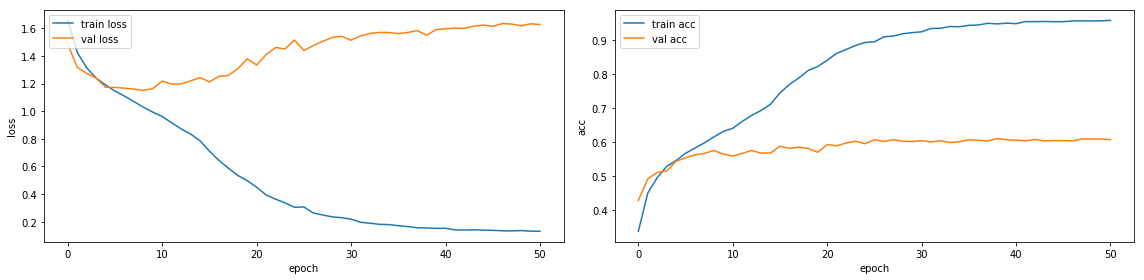

In [13]:
cp_name = './models/1st place/featurewise_flip_seed2.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2))

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, seed=3

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/500
112/112 [==============================] - 4s - loss: 1.7330 - acc: 0.3011 - val_loss: 1.6160 - val_acc: 0.3594
Epoch 2/500
112/112 [==============================] - 4s - loss: 1.5743 - acc: 0.3813 - val_loss: 1.4894 - val_acc: 0.4217
Epoch 3/500
112/112 [==============================] - 3s - loss: 1.4752 - acc: 0.4325 - val_loss: 1.4163 - val_acc: 0.4571
Epoch 4/500
112/112 [==============================] - 4s - loss: 1.3962 - acc: 0.4673 - val_loss: 1.3414 - val_acc: 0.4880
Epoch 5/500
112/112 [==============================] - 3s - loss: 1.3196 - acc: 0.4924 - val_loss: 1.2758 - val_acc: 0.5102
Epoch 6/500
112/112 [==============================] - 4s - loss: 1.2671 - acc: 0.5161 - val_loss: 1.2639 - val_acc: 0.5210
Epoch 7/500
112/112 [==============================] - 3s - loss: 1.2133 - acc: 0.5390 - val_loss: 1.2204 - val_acc: 0.5339
Epoch 8/500
112/112 [==============================] - 3s - loss: 1.1712 - acc: 0.5562 - val_loss: 1.1961 -

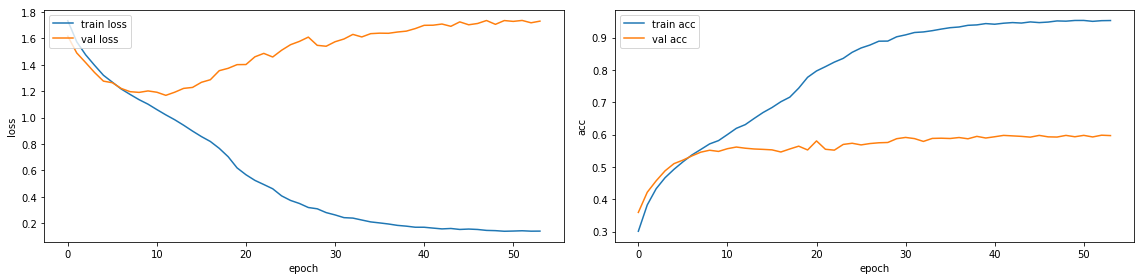

In [14]:
cp_name = './models/1st place/featurewise_flip_seed3.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=3))

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, seed=1, batch_norm

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/500
112/112 [==============================] - 8s - loss: 11.9869 - acc: 0.2501 - val_loss: 12.0976 - val_acc: 0.2494
Epoch 2/500
112/112 [==============================] - 7s - loss: 12.0522 - acc: 0.2523 - val_loss: 12.2095 - val_acc: 0.2425
Epoch 3/500
112/112 [==============================] - 7s - loss: 12.0545 - acc: 0.2521 - val_loss: 12.1079 - val_acc: 0.2488
Epoch 4/500
112/112 [==============================] - 7s - loss: 12.0562 - acc: 0.2520 - val_loss: 12.1031 - val_acc: 0.2491
Epoch 5/500
112/112 [==============================] - 7s - loss: 12.0556 - acc: 0.2520 - val_loss: 12.1031 - val_acc: 0.2491
Epoch 6/500
112/112 [==============================] - 7s - loss: 12.0623 - acc: 0.2516 - val_loss: 12.0976 - val_acc: 0.2494
Epoch 7/500
111/112 [============================>.] - ETA: 0s - loss: 12.0734 - acc: 0.2509Epoch 00006: val_loss did not improve

Epoch 00006: reducing learning rate to 0.05000000074505806.
112/112 [===================

112/112 [==============================] - 7s - loss: 12.0578 - acc: 0.2519 - val_loss: 12.2095 - val_acc: 0.2425
Epoch 33/500
112/112 [==============================] - 7s - loss: 12.0640 - acc: 0.2515 - val_loss: 12.1079 - val_acc: 0.2488
Epoch 34/500
112/112 [==============================] - 7s - loss: 12.0584 - acc: 0.2519 - val_loss: 12.1031 - val_acc: 0.2491
Epoch 35/500
112/112 [==============================] - 7s - loss: 12.0652 - acc: 0.2515 - val_loss: 12.1031 - val_acc: 0.2491
Epoch 36/500
112/112 [==============================] - 7s - loss: 12.0590 - acc: 0.2518 - val_loss: 12.0976 - val_acc: 0.2494
Epoch 37/500
111/112 [============================>.] - ETA: 0s - loss: 12.0643 - acc: 0.2515Epoch 00036: val_loss did not improve

Epoch 00036: reducing learning rate to 0.0007812500116415322.
112/112 [==============================] - 7s - loss: 12.0635 - acc: 0.2516 - val_loss: 12.2095 - val_acc: 0.2425
Epoch 38/500
112/112 [==============================] - 7s - loss: 12.

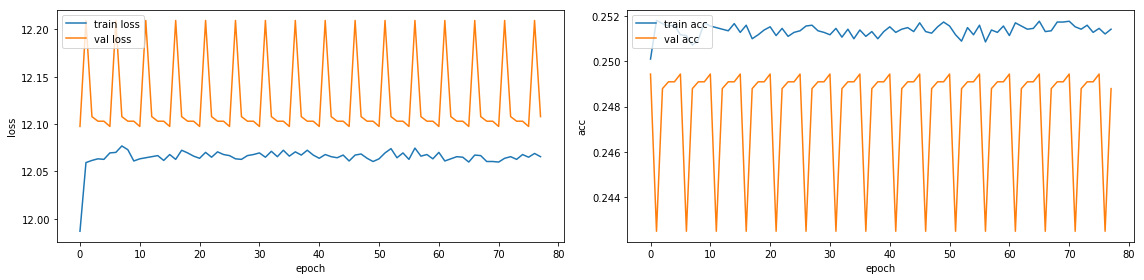

In [19]:
cp_name = './models/1st place/featurewise_flip_seed1_bn.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, seed=1, batch_norm, lr_initial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 8s - loss: 4.0175 - acc: 0.2199 - val_loss: 1.9619 - val_acc: 0.2871
Epoch 2/500
112/112 [==============================] - 7s - loss: 1.7590 - acc: 0.3066 - val_loss: 1.7329 - val_acc: 0.2965
Epoch 3/500
112/112 [==============================] - 7s - loss: 1.6069 - acc: 0.3770 - val_loss: 1.6049 - val_acc: 0.3773
Epoch 4/500
112/112 [==============================] - 7s - loss: 1.5002 - acc: 0.4246 - val_loss: 1.4924 - val_acc: 0.4256
Epoch 5/500
112/112 [==============================] - 7s - loss: 1.4211 - acc: 0.4528 - val_loss: 1.4104 - val_acc: 0.4532
Epoch 6/500
112/112 [==============================] - 7s - loss: 1.3534 - acc: 0.4840 - val_loss: 1.3527 - val_acc: 0.4821
Epoch 7/500
112/112 [==============================] - 7s - loss: 1.3141 - acc: 0.4983 - val_loss: 1.3205 - val_acc: 0.4889
Epoch 8/500
112/112 [==============================] - 7s - loss: 1.2721 - acc: 0.5125 - val_loss: 1.3014 

112/112 [==============================] - 7s - loss: 0.6314 - acc: 0.7749 - val_loss: 1.0812 - val_acc: 0.6105
Epoch 57/500
111/112 [============================>.] - ETA: 0s - loss: 0.6220 - acc: 0.7785Epoch 00056: val_loss did not improve

Epoch 00056: reducing learning rate to 0.0006249999860301614.
112/112 [==============================] - 7s - loss: 0.6229 - acc: 0.7781 - val_loss: 1.0842 - val_acc: 0.6113
Epoch 58/500
112/112 [==============================] - 7s - loss: 0.6245 - acc: 0.7767 - val_loss: 1.0831 - val_acc: 0.6128
Epoch 59/500
112/112 [==============================] - 7s - loss: 0.6204 - acc: 0.7817 - val_loss: 1.0806 - val_acc: 0.6200
Epoch 60/500
112/112 [==============================] - 7s - loss: 0.6237 - acc: 0.7759 - val_loss: 1.0819 - val_acc: 0.6161
Epoch 61/500
112/112 [==============================] - 7s - loss: 0.6221 - acc: 0.7788 - val_loss: 1.0773 - val_acc: 0.6197
Epoch 62/500
111/112 [============================>.] - ETA: 0s - loss: 0.6176 - ac

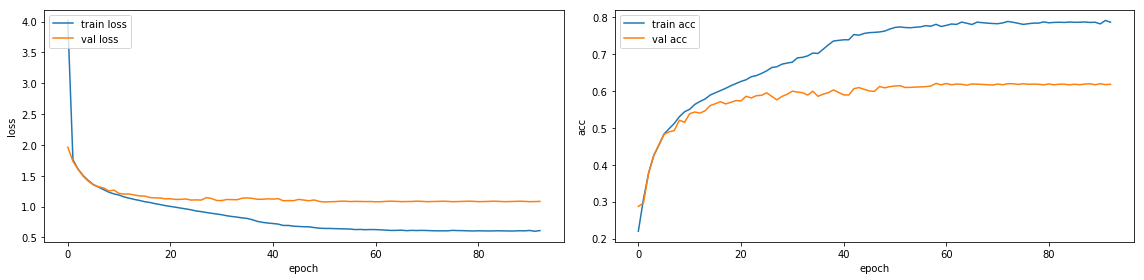

In [20]:
cp_name = './models/1st place/featurewise_flip_seed1_bn_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, seed=1, batch_norm after dense, lr_initial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 9s - loss: 1.7228 - acc: 0.3453 - val_loss: 1.7158 - val_acc: 0.3122
Epoch 2/500
112/112 [==============================] - 7s - loss: 1.4842 - acc: 0.4363 - val_loss: 1.5269 - val_acc: 0.4184
Epoch 3/500
112/112 [==============================] - 7s - loss: 1.3960 - acc: 0.4679 - val_loss: 1.3683 - val_acc: 0.4754
Epoch 4/500
112/112 [==============================] - 7s - loss: 1.3309 - acc: 0.4984 - val_loss: 1.3158 - val_acc: 0.4982
Epoch 5/500
112/112 [==============================] - 7s - loss: 1.2881 - acc: 0.5161 - val_loss: 1.2961 - val_acc: 0.4985
Epoch 6/500
112/112 [==============================] - 7s - loss: 1.2528 - acc: 0.5319 - val_loss: 1.2464 - val_acc: 0.5287
Epoch 7/500
112/112 [==============================] - 7s - loss: 1.2162 - acc: 0.5428 - val_loss: 1.2501 - val_acc: 0.5282
Epoch 8/500
112/112 [==============================] - 7s - loss: 1.1923 - acc: 0.5548 - val_loss: 1.2131 

112/112 [==============================] - 7s - loss: 0.8086 - acc: 0.7035 - val_loss: 1.0984 - val_acc: 0.6029
Epoch 30/500
112/112 [==============================] - 7s - loss: 0.7957 - acc: 0.7093 - val_loss: 1.0932 - val_acc: 0.6089
Epoch 31/500
112/112 [==============================] - 7s - loss: 0.7862 - acc: 0.7130 - val_loss: 1.0990 - val_acc: 0.6130
Epoch 32/500
112/112 [==============================] - 7s - loss: 0.7804 - acc: 0.7133 - val_loss: 1.1281 - val_acc: 0.5969
Epoch 33/500
112/112 [==============================] - 7s - loss: 0.7690 - acc: 0.7176 - val_loss: 1.1132 - val_acc: 0.6125
Epoch 34/500
111/112 [============================>.] - ETA: 0s - loss: 0.7554 - acc: 0.7239Epoch 00033: val_loss did not improve

Epoch 00033: reducing learning rate to 0.0024999999441206455.
112/112 [==============================] - 7s - loss: 0.7549 - acc: 0.7242 - val_loss: 1.1138 - val_acc: 0.6101
Epoch 35/500
112/112 [==============================] - 7s - loss: 0.7386 - acc: 0.

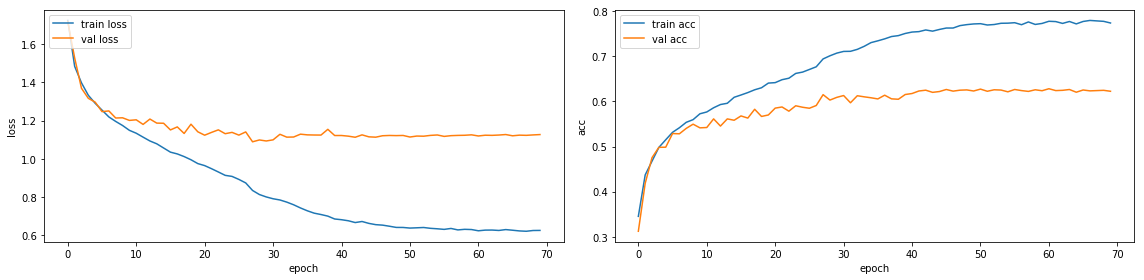

In [21]:
cp_name = './models/1st place/featurewise_flip_seed1_bndense_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , es_patience=41
                       , epochs=500)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, rotate, seed=1

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/200
112/112 [==============================] - 5s - loss: 1.6977 - acc: 0.3164 - val_loss: 1.5579 - val_acc: 0.3909
Epoch 2/200
112/112 [==============================] - 5s - loss: 1.4834 - acc: 0.4295 - val_loss: 1.3881 - val_acc: 0.4628
Epoch 3/200
112/112 [==============================] - 5s - loss: 1.3714 - acc: 0.4735 - val_loss: 1.2957 - val_acc: 0.4991
Epoch 4/200
112/112 [==============================] - 5s - loss: 1.2938 - acc: 0.5074 - val_loss: 1.2443 - val_acc: 0.5267
Epoch 5/200
112/112 [==============================] - 5s - loss: 1.2334 - acc: 0.5294 - val_loss: 1.2015 - val_acc: 0.5417
Epoch 6/200
112/112 [==============================] - 5s - loss: 1.1919 - acc: 0.5484 - val_loss: 1.1893 - val_acc: 0.5531
Epoch 7/200
112/112 [==============================] - 5s - loss: 1.1550 - acc: 0.5629 - val_loss: 1.1941 - val_acc: 0.5468
Epoch 8/200
112/112 [==============================] - 5s - loss: 1.1078 - acc: 0.5825 - val_loss: 1.1947 -

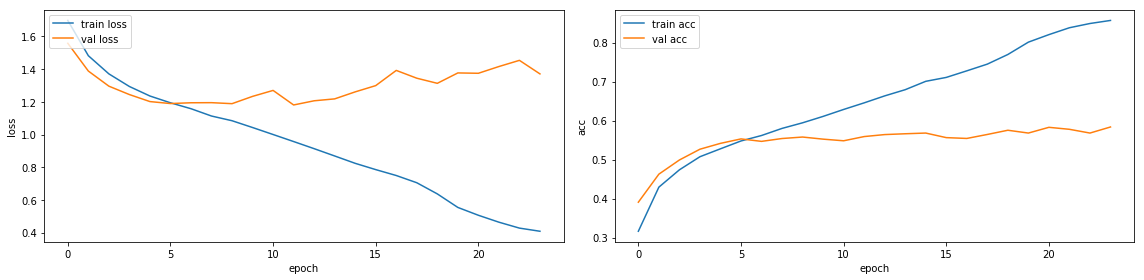

In [15]:
cp_name = './models/1st place/rotate_seed1.hdf5'

# build model
model = helper.build_model('1st_place')

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                      , rotation_range=.45)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, seed=1

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/200
112/112 [==============================] - 5s - loss: 1.7298 - acc: 0.2993 - val_loss: 1.5833 - val_acc: 0.3934
Epoch 2/200
112/112 [==============================] - 5s - loss: 1.5428 - acc: 0.4036 - val_loss: 1.4390 - val_acc: 0.4484
Epoch 3/200
112/112 [==============================] - 5s - loss: 1.4139 - acc: 0.4569 - val_loss: 1.3205 - val_acc: 0.4922
Epoch 4/200
112/112 [==============================] - 5s - loss: 1.3387 - acc: 0.4869 - val_loss: 1.2748 - val_acc: 0.5048
Epoch 5/200
112/112 [==============================] - 5s - loss: 1.2924 - acc: 0.5060 - val_loss: 1.2268 - val_acc: 0.5246
Epoch 6/200
112/112 [==============================] - 5s - loss: 1.2475 - acc: 0.5280 - val_loss: 1.2153 - val_acc: 0.5345
Epoch 7/200
112/112 [==============================] - 4s - loss: 1.2208 - acc: 0.5352 - val_loss: 1.2163 - val_acc: 0.5279
Epoch 8/200
112/112 [==============================] - 5s - loss: 1.1930 - acc: 0.5477 - val_loss: 1.2063 -

112/112 [==============================] - 5s - loss: 0.8575 - acc: 0.6808 - val_loss: 1.0706 - val_acc: 0.5993
Epoch 30/200
112/112 [==============================] - 4s - loss: 0.8463 - acc: 0.6843 - val_loss: 1.0783 - val_acc: 0.5999
Epoch 31/200
112/112 [==============================] - 4s - loss: 0.8408 - acc: 0.6875 - val_loss: 1.0932 - val_acc: 0.5915
Epoch 32/200
112/112 [==============================] - 5s - loss: 0.8251 - acc: 0.6950 - val_loss: 1.0701 - val_acc: 0.6044
Epoch 33/200
110/112 [============================>.] - ETA: 0s - loss: 0.8097 - acc: 0.6991Epoch 00032: val_loss did not improve

Epoch 00032: reducing learning rate to 0.02500000037252903.
112/112 [==============================] - 4s - loss: 0.8092 - acc: 0.6990 - val_loss: 1.0739 - val_acc: 0.6140
Epoch 34/200
112/112 [==============================] - 5s - loss: 0.7851 - acc: 0.7110 - val_loss: 1.0634 - val_acc: 0.6161
Epoch 35/200
112/112 [==============================] - 4s - loss: 0.7686 - acc: 0.71

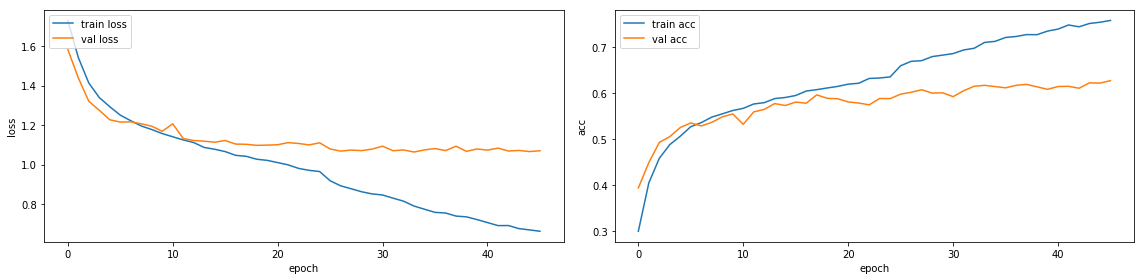

In [16]:
cp_name = './models/1st place/widthshift_seed1.hdf5'

# build model
model = helper.build_model('1st_place')

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                      , width_shift_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, height_shift, seed=1

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/200
112/112 [==============================] - 5s - loss: 1.7612 - acc: 0.2760 - val_loss: 1.6480 - val_acc: 0.3504
Epoch 2/200
112/112 [==============================] - 4s - loss: 1.6282 - acc: 0.3576 - val_loss: 1.5158 - val_acc: 0.4010
Epoch 3/200
112/112 [==============================] - 5s - loss: 1.5477 - acc: 0.3962 - val_loss: 1.4210 - val_acc: 0.4565
Epoch 4/200
112/112 [==============================] - 5s - loss: 1.4595 - acc: 0.4376 - val_loss: 1.3780 - val_acc: 0.4769
Epoch 5/200
112/112 [==============================] - 5s - loss: 1.3910 - acc: 0.4645 - val_loss: 1.3054 - val_acc: 0.4916
Epoch 6/200
112/112 [==============================] - 4s - loss: 1.3451 - acc: 0.4845 - val_loss: 1.2786 - val_acc: 0.5126
Epoch 7/200
112/112 [==============================] - 5s - loss: 1.3016 - acc: 0.5075 - val_loss: 1.2371 - val_acc: 0.5324
Epoch 8/200
112/112 [==============================] - 5s - loss: 1.2827 - acc: 0.5117 - val_loss: 1.2311 -

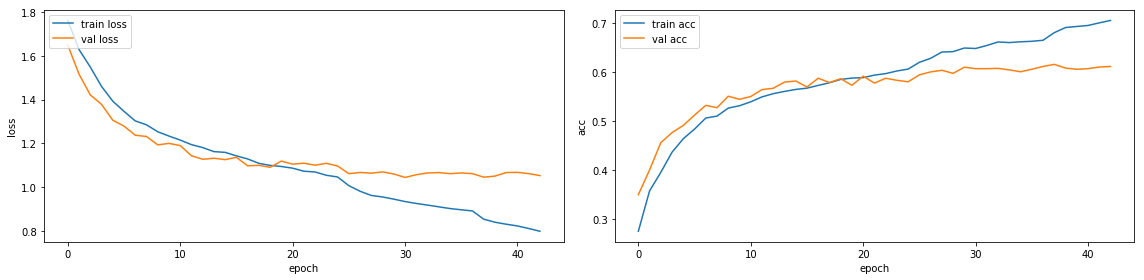

In [17]:
cp_name = './models/1st place/heightshift_seed1.hdf5'

# build model
model = helper.build_model('1st_place')

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                      , height_shift_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, seed=1, lrinitial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 5s - loss: 1.7792 - acc: 0.2684 - val_loss: 1.7172 - val_acc: 0.3292
Epoch 2/500
112/112 [==============================] - 4s - loss: 1.6956 - acc: 0.3230 - val_loss: 1.6400 - val_acc: 0.3670
Epoch 3/500
112/112 [==============================] - 4s - loss: 1.6241 - acc: 0.3660 - val_loss: 1.5511 - val_acc: 0.4037
Epoch 4/500
112/112 [==============================] - 4s - loss: 1.5550 - acc: 0.3982 - val_loss: 1.5140 - val_acc: 0.4217
Epoch 5/500
112/112 [==============================] - 4s - loss: 1.4948 - acc: 0.4252 - val_loss: 1.4275 - val_acc: 0.4559
Epoch 6/500
112/112 [==============================] - 4s - loss: 1.4447 - acc: 0.4493 - val_loss: 1.3897 - val_acc: 0.4727
Epoch 7/500
112/112 [==============================] - 4s - loss: 1.4075 - acc: 0.4624 - val_loss: 1.3562 - val_acc: 0.4856
Epoch 8/500
112/112 [==============================] - 4s - loss: 1.3701 - acc: 0.4791 - val_loss: 1.3515 

112/112 [==============================] - 4s - loss: 1.1168 - acc: 0.5805 - val_loss: 1.1340 - val_acc: 0.5672
Epoch 27/500
112/112 [==============================] - 4s - loss: 1.1088 - acc: 0.5855 - val_loss: 1.1331 - val_acc: 0.5711
Epoch 28/500
112/112 [==============================] - 4s - loss: 1.1046 - acc: 0.5895 - val_loss: 1.1283 - val_acc: 0.5696
Epoch 29/500
112/112 [==============================] - 4s - loss: 1.0911 - acc: 0.5902 - val_loss: 1.1304 - val_acc: 0.5714
Epoch 30/500
112/112 [==============================] - 4s - loss: 1.0813 - acc: 0.5962 - val_loss: 1.1384 - val_acc: 0.5747
Epoch 31/500
112/112 [==============================] - 4s - loss: 1.0816 - acc: 0.5953 - val_loss: 1.1296 - val_acc: 0.5723
Epoch 32/500
112/112 [==============================] - 4s - loss: 1.0731 - acc: 0.6010 - val_loss: 1.1213 - val_acc: 0.5798
Epoch 33/500
112/112 [==============================] - 4s - loss: 1.0676 - acc: 0.5997 - val_loss: 1.1194 - val_acc: 0.5765
Epoch 34/500


112/112 [==============================] - 4s - loss: 0.9057 - acc: 0.6635 - val_loss: 1.0626 - val_acc: 0.6095
Epoch 86/500
112/112 [==============================] - 4s - loss: 0.9045 - acc: 0.6618 - val_loss: 1.0574 - val_acc: 0.6074
Epoch 87/500
112/112 [==============================] - 4s - loss: 0.9033 - acc: 0.6644 - val_loss: 1.0590 - val_acc: 0.6101
Epoch 88/500
112/112 [==============================] - 4s - loss: 0.9045 - acc: 0.6645 - val_loss: 1.0619 - val_acc: 0.6092
Epoch 89/500
112/112 [==============================] - 4s - loss: 0.9060 - acc: 0.6620 - val_loss: 1.0606 - val_acc: 0.6023
Epoch 90/500
110/112 [============================>.] - ETA: 0s - loss: 0.9016 - acc: 0.6645Epoch 00089: val_loss did not improve

Epoch 00089: reducing learning rate to 0.0003124999930150807.
112/112 [==============================] - 4s - loss: 0.9019 - acc: 0.6643 - val_loss: 1.0575 - val_acc: 0.6053
Epoch 91/500
112/112 [==============================] - 4s - loss: 0.9059 - acc: 0.

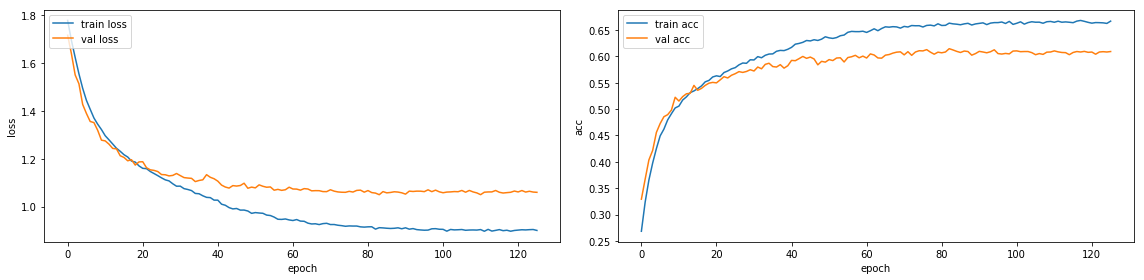

In [22]:
cp_name = './models/1st place/widthshift_seed1_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place')

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, batch_norm, seed=1, lrinitial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 8s - loss: 3.9118 - acc: 0.2263 - val_loss: 1.8399 - val_acc: 0.2754
Epoch 2/500
112/112 [==============================] - 7s - loss: 1.7055 - acc: 0.3287 - val_loss: 1.6839 - val_acc: 0.3217
Epoch 3/500
112/112 [==============================] - 7s - loss: 1.5798 - acc: 0.3846 - val_loss: 1.5398 - val_acc: 0.3992
Epoch 4/500
112/112 [==============================] - 7s - loss: 1.5016 - acc: 0.4169 - val_loss: 1.4281 - val_acc: 0.4538
Epoch 5/500
112/112 [==============================] - 7s - loss: 1.4457 - acc: 0.4430 - val_loss: 1.3847 - val_acc: 0.4652
Epoch 6/500
112/112 [==============================] - 7s - loss: 1.3910 - acc: 0.4692 - val_loss: 1.3666 - val_acc: 0.4704
Epoch 7/500
112/112 [==============================] - 7s - loss: 1.3559 - acc: 0.4788 - val_loss: 1.3470 - val_acc: 0.4835
Epoch 8/500
112/112 [==============================] - 7s - loss: 1.3248 - acc: 0.4969 - val_loss: 1.3020 

112/112 [==============================] - 7s - loss: 0.9115 - acc: 0.6646 - val_loss: 1.0676 - val_acc: 0.6047
Epoch 58/500
112/112 [==============================] - 7s - loss: 0.9024 - acc: 0.6669 - val_loss: 1.0516 - val_acc: 0.6131
Epoch 59/500
112/112 [==============================] - 7s - loss: 0.9016 - acc: 0.6643 - val_loss: 1.0561 - val_acc: 0.6068
Epoch 60/500
112/112 [==============================] - 7s - loss: 0.9032 - acc: 0.6650 - val_loss: 1.0524 - val_acc: 0.6083
Epoch 61/500
112/112 [==============================] - 7s - loss: 0.9005 - acc: 0.6663 - val_loss: 1.0631 - val_acc: 0.6066
Epoch 62/500
112/112 [==============================] - 7s - loss: 0.9012 - acc: 0.6670 - val_loss: 1.0708 - val_acc: 0.6035
Epoch 63/500
112/112 [==============================] - 7s - loss: 0.9024 - acc: 0.6638 - val_loss: 1.0575 - val_acc: 0.6086
Epoch 64/500
111/112 [============================>.] - ETA: 0s - loss: 0.8966 - acc: 0.6684Epoch 00063: val_loss did not improve

Epoch 0

112/112 [==============================] - 7s - loss: 0.8610 - acc: 0.6830 - val_loss: 1.0406 - val_acc: 0.6203
Epoch 120/500
112/112 [==============================] - 7s - loss: 0.8656 - acc: 0.6783 - val_loss: 1.0387 - val_acc: 0.6203
Epoch 121/500
112/112 [==============================] - 7s - loss: 0.8597 - acc: 0.6831 - val_loss: 1.0372 - val_acc: 0.6208
Epoch 122/500
112/112 [==============================] - 7s - loss: 0.8605 - acc: 0.6798 - val_loss: 1.0447 - val_acc: 0.6158
Epoch 123/500
112/112 [==============================] - 7s - loss: 0.8535 - acc: 0.6862 - val_loss: 1.0409 - val_acc: 0.6203
Epoch 124/500
112/112 [==============================] - 7s - loss: 0.8612 - acc: 0.6830 - val_loss: 1.0410 - val_acc: 0.6191
Epoch 125/500
112/112 [==============================] - 7s - loss: 0.8586 - acc: 0.6846 - val_loss: 1.0382 - val_acc: 0.6200
Epoch 126/500
112/112 [==============================] - 7s - loss: 0.8585 - acc: 0.6825 - val_loss: 1.0371 - val_acc: 0.6214
Epoch 

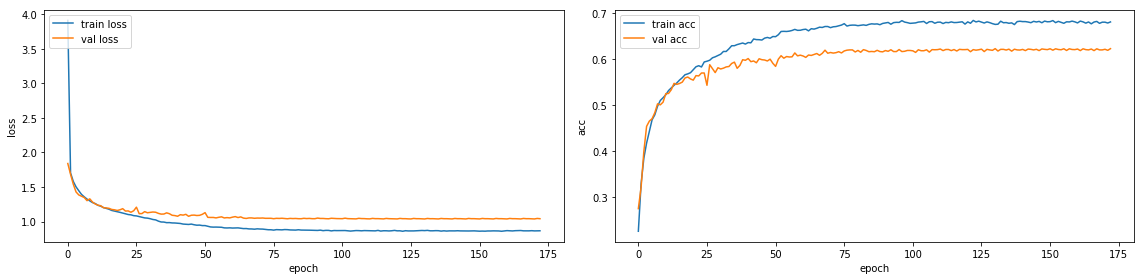

In [23]:
cp_name = './models/1st place/widthshift_bn_seed1_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, batch_norm, seed=1, lrinitial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 8s - loss: 5.7032 - acc: 0.1895 - val_loss: 4.8081 - val_acc: 0.1973
Epoch 2/500
112/112 [==============================] - 7s - loss: 3.1710 - acc: 0.2326 - val_loss: 1.7564 - val_acc: 0.2755
Epoch 3/500
112/112 [==============================] - 7s - loss: 1.7424 - acc: 0.2829 - val_loss: 1.7126 - val_acc: 0.3091
Epoch 4/500
112/112 [==============================] - 7s - loss: 1.7105 - acc: 0.3083 - val_loss: 1.6713 - val_acc: 0.3301
Epoch 5/500
112/112 [==============================] - 7s - loss: 1.6815 - acc: 0.3252 - val_loss: 1.6511 - val_acc: 0.3280
Epoch 6/500
112/112 [==============================] - 7s - loss: 1.6395 - acc: 0.3471 - val_loss: 1.5981 - val_acc: 0.3535
Epoch 7/500
112/112 [==============================] - 7s - loss: 1.6040 - acc: 0.3659 - val_loss: 1.5336 - val_acc: 0.4025
Epoch 8/500
112/112 [==============================] - 7s - loss: 1.5737 - acc: 0.3833 - val_loss: 1.5464 

112/112 [==============================] - 7s - loss: 1.0802 - acc: 0.5947 - val_loss: 1.0533 - val_acc: 0.5990
Epoch 56/500
112/112 [==============================] - 7s - loss: 1.0806 - acc: 0.5937 - val_loss: 1.0690 - val_acc: 0.6014
Epoch 57/500
112/112 [==============================] - 7s - loss: 1.0726 - acc: 0.5973 - val_loss: 1.0482 - val_acc: 0.6158
Epoch 58/500
112/112 [==============================] - 7s - loss: 1.0782 - acc: 0.5954 - val_loss: 1.0501 - val_acc: 0.6107
Epoch 59/500
112/112 [==============================] - 7s - loss: 1.0718 - acc: 0.5985 - val_loss: 1.0565 - val_acc: 0.6026
Epoch 60/500
112/112 [==============================] - 7s - loss: 1.0649 - acc: 0.6026 - val_loss: 1.0444 - val_acc: 0.6179
Epoch 61/500
112/112 [==============================] - 7s - loss: 1.0634 - acc: 0.6020 - val_loss: 1.0704 - val_acc: 0.6038
Epoch 62/500
112/112 [==============================] - 7s - loss: 1.0676 - acc: 0.5989 - val_loss: 1.0567 - val_acc: 0.6074
Epoch 63/500


112/112 [==============================] - 7s - loss: 1.0290 - acc: 0.6162 - val_loss: 1.0193 - val_acc: 0.6173
Epoch 86/500
111/112 [============================>.] - ETA: 0s - loss: 1.0284 - acc: 0.6123Epoch 00085: val_loss did not improve

Epoch 00085: reducing learning rate to 0.0006249999860301614.
112/112 [==============================] - 7s - loss: 1.0289 - acc: 0.6122 - val_loss: 1.0213 - val_acc: 0.6149
Epoch 87/500
112/112 [==============================] - 7s - loss: 1.0240 - acc: 0.6152 - val_loss: 1.0152 - val_acc: 0.6161
Epoch 88/500
112/112 [==============================] - 7s - loss: 1.0196 - acc: 0.6167 - val_loss: 1.0162 - val_acc: 0.6180
Epoch 89/500
112/112 [==============================] - 7s - loss: 1.0258 - acc: 0.6170 - val_loss: 1.0209 - val_acc: 0.6143
Epoch 90/500
112/112 [==============================] - 7s - loss: 1.0226 - acc: 0.6195 - val_loss: 1.0185 - val_acc: 0.6143
Epoch 91/500
112/112 [==============================] - 7s - loss: 1.0191 - acc: 0.

112/112 [==============================] - 7s - loss: 1.0139 - acc: 0.6205 - val_loss: 1.0101 - val_acc: 0.6185
Epoch 148/500
112/112 [==============================] - 7s - loss: 1.0137 - acc: 0.6204 - val_loss: 1.0092 - val_acc: 0.6197
Epoch 149/500
111/112 [============================>.] - ETA: 0s - loss: 1.0145 - acc: 0.6178Epoch 00148: val_loss did not improve

Epoch 00148: reducing learning rate to 1.9531249563442543e-05.
112/112 [==============================] - 7s - loss: 1.0145 - acc: 0.6179 - val_loss: 1.0127 - val_acc: 0.6179
Epoch 150/500
112/112 [==============================] - 7s - loss: 1.0140 - acc: 0.6207 - val_loss: 1.0106 - val_acc: 0.6167
Epoch 151/500
112/112 [==============================] - 7s - loss: 1.0117 - acc: 0.6214 - val_loss: 1.0128 - val_acc: 0.6122
Epoch 152/500
112/112 [==============================] - 7s - loss: 1.0124 - acc: 0.6215 - val_loss: 1.0097 - val_acc: 0.6176
Epoch 153/500
112/112 [==============================] - 7s - loss: 1.0128 - 

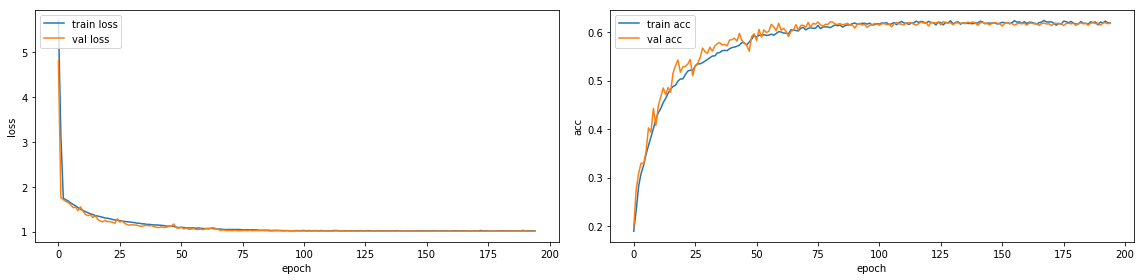

In [24]:
cp_name = './models/1st place/widthheightshift_bn_seed1_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, batch_norm, seed=1, lrinitial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 11s - loss: 5.6373 - acc: 0.1919 - val_loss: 4.7556 - val_acc: 0.2079
Epoch 2/500
112/112 [==============================] - 7s - loss: 2.7685 - acc: 0.2421 - val_loss: 1.7544 - val_acc: 0.2809
Epoch 3/500
112/112 [==============================] - 7s - loss: 1.7368 - acc: 0.2859 - val_loss: 1.7404 - val_acc: 0.2908
Epoch 4/500
112/112 [==============================] - 7s - loss: 1.7054 - acc: 0.3115 - val_loss: 1.6979 - val_acc: 0.3184
Epoch 5/500
112/112 [==============================] - 7s - loss: 1.6747 - acc: 0.3308 - val_loss: 1.6291 - val_acc: 0.3436
Epoch 6/500
112/112 [==============================] - 7s - loss: 1.6493 - acc: 0.3438 - val_loss: 1.6049 - val_acc: 0.3557
Epoch 7/500
112/112 [==============================] - 7s - loss: 1.6067 - acc: 0.3667 - val_loss: 1.6784 - val_acc: 0.3580
Epoch 8/500
112/112 [==============================] - 7s - loss: 1.5696 - acc: 0.3854 - val_loss: 1.4902

112/112 [==============================] - 7s - loss: 1.0866 - acc: 0.5924 - val_loss: 1.0851 - val_acc: 0.5933
Epoch 58/500
112/112 [==============================] - 7s - loss: 1.0926 - acc: 0.5914 - val_loss: 1.0524 - val_acc: 0.6050
Epoch 59/500
112/112 [==============================] - 7s - loss: 1.0855 - acc: 0.5899 - val_loss: 1.0638 - val_acc: 0.6029
Epoch 60/500
112/112 [==============================] - 7s - loss: 1.0835 - acc: 0.5918 - val_loss: 1.0668 - val_acc: 0.5999
Epoch 61/500
112/112 [==============================] - 7s - loss: 1.0806 - acc: 0.5916 - val_loss: 1.0698 - val_acc: 0.6021
Epoch 62/500
112/112 [==============================] - 7s - loss: 1.0812 - acc: 0.5936 - val_loss: 1.0652 - val_acc: 0.6065
Epoch 63/500
112/112 [==============================] - 7s - loss: 1.0779 - acc: 0.5932 - val_loss: 1.0669 - val_acc: 0.5999
Epoch 64/500
111/112 [============================>.] - ETA: 0s - loss: 1.0780 - acc: 0.5940Epoch 00063: val_loss did not improve

Epoch 0

112/112 [==============================] - 7s - loss: 1.0350 - acc: 0.6132 - val_loss: 1.0364 - val_acc: 0.6128
Epoch 89/500
112/112 [==============================] - 7s - loss: 1.0425 - acc: 0.6077 - val_loss: 1.0433 - val_acc: 0.6056
Epoch 90/500
112/112 [==============================] - 7s - loss: 1.0314 - acc: 0.6139 - val_loss: 1.0406 - val_acc: 0.6128
Epoch 91/500
112/112 [==============================] - 7s - loss: 1.0395 - acc: 0.6119 - val_loss: 1.0353 - val_acc: 0.6124
Epoch 92/500
111/112 [============================>.] - ETA: 0s - loss: 1.0330 - acc: 0.6131- ETAEpoch 00091: val_loss did not improve

Epoch 00091: reducing learning rate to 0.0003124999930150807.
112/112 [==============================] - 7s - loss: 1.0328 - acc: 0.6131 - val_loss: 1.0409 - val_acc: 0.6113
Epoch 93/500
112/112 [==============================] - 7s - loss: 1.0376 - acc: 0.6137 - val_loss: 1.0335 - val_acc: 0.6134
Epoch 94/500
112/112 [==============================] - 7s - loss: 1.0375 - ac

112/112 [==============================] - 7s - loss: 1.0325 - acc: 0.6146 - val_loss: 1.0279 - val_acc: 0.6197
Epoch 152/500
111/112 [============================>.] - ETA: 0s - loss: 1.0345 - acc: 0.6126Epoch 00151: val_loss did not improve

Epoch 00151: reducing learning rate to 1.220703097715159e-06.
112/112 [==============================] - 7s - loss: 1.0344 - acc: 0.6128 - val_loss: 1.0344 - val_acc: 0.6197
Epoch 153/500
112/112 [==============================] - 7s - loss: 1.0359 - acc: 0.6119 - val_loss: 1.0281 - val_acc: 0.6191
Epoch 154/500
112/112 [==============================] - 7s - loss: 1.0356 - acc: 0.6112 - val_loss: 1.0361 - val_acc: 0.6155
Epoch 155/500
112/112 [==============================] - 7s - loss: 1.0343 - acc: 0.6120 - val_loss: 1.0305 - val_acc: 0.6185
Epoch 156/500
112/112 [==============================] - 7s - loss: 1.0288 - acc: 0.6121 - val_loss: 1.0278 - val_acc: 0.6197
Epoch 157/500
111/112 [============================>.] - ETA: 0s - loss: 1.032

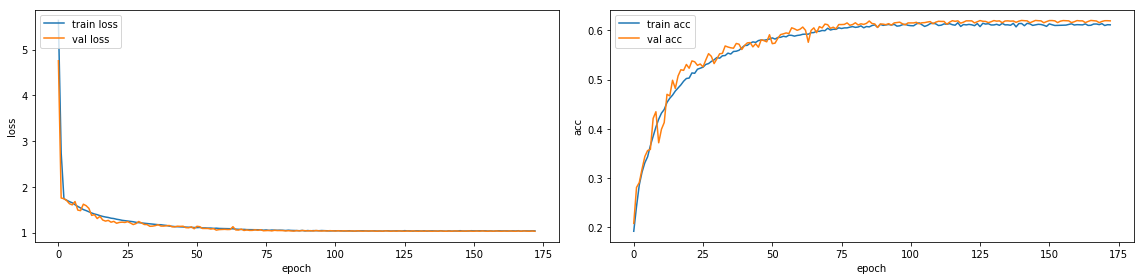

In [26]:
cp_name = './models/1st place/widthheightshiftrotate_bn_seed1_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom, batch_norm, seed=1, lrinitial0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 22s - loss: 2.8442 - acc: 0.2270 - val_loss: 1.8577 - val_acc: 0.2489
Epoch 2/500
112/112 [==============================] - 19s - loss: 1.8518 - acc: 0.2505 - val_loss: 1.7606 - val_acc: 0.2795
Epoch 3/500
112/112 [==============================] - 19s - loss: 1.7984 - acc: 0.2648 - val_loss: 1.7680 - val_acc: 0.2726
Epoch 4/500
112/112 [==============================] - 19s - loss: 1.7783 - acc: 0.2700 - val_loss: 1.7647 - val_acc: 0.2651
Epoch 5/500
112/112 [==============================] - 19s - loss: 1.7529 - acc: 0.2857 - val_loss: 1.7077 - val_acc: 0.3236
Epoch 6/500
112/112 [==============================] - 19s - loss: 1.7232 - acc: 0.3014 - val_loss: 1.6708 - val_acc: 0.3531
Epoch 7/500
112/112 [==============================] - 19s - loss: 1.7002 - acc: 0.3177 - val_loss: 1.6193 - val_acc: 0.3593
Epoch 8/500
112/112 [==============================] - 20s - loss: 1.6719 - acc: 0.3343 - val_loss:

112/112 [==============================] - 19s - loss: 1.3357 - acc: 0.4930 - val_loss: 1.2217 - val_acc: 0.5348
Epoch 28/500
112/112 [==============================] - 20s - loss: 1.3264 - acc: 0.4953 - val_loss: 1.2190 - val_acc: 0.5229
Epoch 29/500
112/112 [==============================] - 21s - loss: 1.3177 - acc: 0.4979 - val_loss: 1.2384 - val_acc: 0.5354
Epoch 30/500
112/112 [==============================] - 20s - loss: 1.3088 - acc: 0.5034 - val_loss: 1.2091 - val_acc: 0.5457
Epoch 31/500
112/112 [==============================] - 19s - loss: 1.3033 - acc: 0.5039 - val_loss: 1.1956 - val_acc: 0.5465
Epoch 32/500
112/112 [==============================] - 20s - loss: 1.3024 - acc: 0.5036 - val_loss: 1.1975 - val_acc: 0.5387
Epoch 33/500
112/112 [==============================] - 19s - loss: 1.2857 - acc: 0.5115 - val_loss: 1.2459 - val_acc: 0.5276
Epoch 34/500
112/112 [==============================] - 19s - loss: 1.2830 - acc: 0.5149 - val_loss: 1.1972 - val_acc: 0.5524
Epoch

112/112 [==============================] - 19s - loss: 1.1803 - acc: 0.5543 - val_loss: 1.0976 - val_acc: 0.5839
Epoch 57/500
112/112 [==============================] - 19s - loss: 1.1912 - acc: 0.5484 - val_loss: 1.0966 - val_acc: 0.5867
Epoch 58/500
112/112 [==============================] - 19s - loss: 1.1722 - acc: 0.5568 - val_loss: 1.1311 - val_acc: 0.5814
Epoch 59/500
112/112 [==============================] - 19s - loss: 1.1840 - acc: 0.5518 - val_loss: 1.1285 - val_acc: 0.5700
Epoch 60/500
112/112 [==============================] - 19s - loss: 1.1775 - acc: 0.5575 - val_loss: 1.1091 - val_acc: 0.5825
Epoch 61/500
112/112 [==============================] - 19s - loss: 1.1711 - acc: 0.5584 - val_loss: 1.1035 - val_acc: 0.5822
Epoch 62/500
112/112 [==============================] - 19s - loss: 1.1795 - acc: 0.5549 - val_loss: 1.0984 - val_acc: 0.5920
Epoch 63/500
110/112 [============================>.] - ETA: 0s - loss: 1.1720 - acc: 0.5609Epoch 00062: val_loss did not improve



112/112 [==============================] - 20s - loss: 1.1216 - acc: 0.5786 - val_loss: 1.0465 - val_acc: 0.6087
Epoch 116/500
112/112 [==============================] - 19s - loss: 1.1203 - acc: 0.5799 - val_loss: 1.0413 - val_acc: 0.6067
Epoch 117/500
112/112 [==============================] - 20s - loss: 1.1150 - acc: 0.5807 - val_loss: 1.0443 - val_acc: 0.6070
Epoch 118/500
112/112 [==============================] - 19s - loss: 1.1195 - acc: 0.5777 - val_loss: 1.0471 - val_acc: 0.6087
Epoch 119/500
112/112 [==============================] - 20s - loss: 1.1109 - acc: 0.5802 - val_loss: 1.0438 - val_acc: 0.6126
Epoch 120/500
112/112 [==============================] - 20s - loss: 1.1179 - acc: 0.5778 - val_loss: 1.0437 - val_acc: 0.6109
Epoch 121/500
112/112 [==============================] - 20s - loss: 1.1192 - acc: 0.5769 - val_loss: 1.0420 - val_acc: 0.6076
Epoch 122/500
111/112 [============================>.] - ETA: 0s - loss: 1.1148 - acc: 0.5815Epoch 00121: val_loss did not im

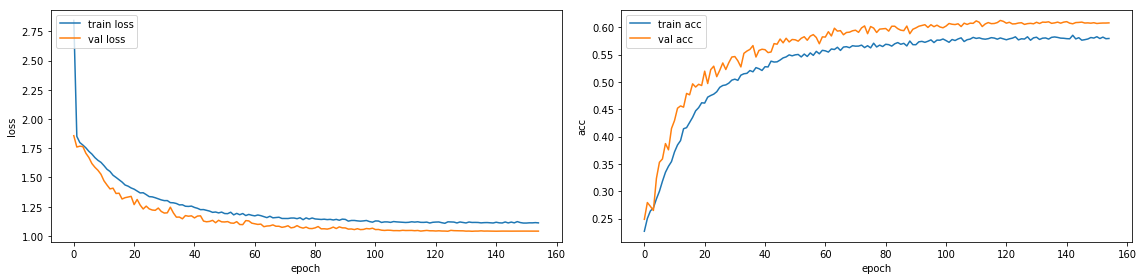

In [7]:
cp_name = './models/1st place/widthheightshiftrotatezoom_bn_seed1_lrinitial0.01.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45, zoom_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom, batch_norm, seed=1, lrinitial0.01, class_weight

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
112/112 [==============================] - 8s - loss: 2.3865 - acc: 0.1734 - val_loss: 1.8795 - val_acc: 0.2177
Epoch 2/500
112/112 [==============================] - 7s - loss: 1.9332 - acc: 0.1991 - val_loss: 1.7699 - val_acc: 0.3372
Epoch 3/500
112/112 [==============================] - 7s - loss: 1.8792 - acc: 0.2220 - val_loss: 1.7953 - val_acc: 0.2815
Epoch 4/500
112/112 [==============================] - 7s - loss: 1.8468 - acc: 0.2431 - val_loss: 1.7400 - val_acc: 0.3325
Epoch 5/500
112/112 [==============================] - 7s - loss: 1.8067 - acc: 0.2636 - val_loss: 1.7019 - val_acc: 0.3420
Epoch 6/500
112/112 [==============================] - 7s - loss: 1.7827 - acc: 0.2829 - val_loss: 1.6568 - val_acc: 0.3740
Epoch 7/500
112/112 [==============================] - 7s - loss: 1.7597 - acc: 0.2896 - val_loss: 1.6528 - val_acc: 0.3573
Epoch 8/500
112/112 [==============================] - 7s - loss: 1.7280 - acc: 0.3087 - val_loss: 1.6448 

112/112 [==============================] - 7s - loss: 1.2408 - acc: 0.5139 - val_loss: 1.1816 - val_acc: 0.5443
Epoch 57/500
112/112 [==============================] - 7s - loss: 1.2447 - acc: 0.5153 - val_loss: 1.1873 - val_acc: 0.5452
Epoch 58/500
112/112 [==============================] - 6s - loss: 1.2253 - acc: 0.5205 - val_loss: 1.2110 - val_acc: 0.5438
Epoch 59/500
112/112 [==============================] - 7s - loss: 1.2324 - acc: 0.5180 - val_loss: 1.3088 - val_acc: 0.5170
Epoch 60/500
112/112 [==============================] - 7s - loss: 1.2128 - acc: 0.5260 - val_loss: 1.1785 - val_acc: 0.5521
Epoch 61/500
112/112 [==============================] - 7s - loss: 1.2240 - acc: 0.5235 - val_loss: 1.2238 - val_acc: 0.5387
Epoch 62/500
112/112 [==============================] - 7s - loss: 1.2151 - acc: 0.5249 - val_loss: 1.1195 - val_acc: 0.5747
Epoch 63/500
112/112 [==============================] - 7s - loss: 1.2164 - acc: 0.5296 - val_loss: 1.2180 - val_acc: 0.5399
Epoch 64/500


112/112 [==============================] - 7s - loss: 1.1298 - acc: 0.5525 - val_loss: 1.1218 - val_acc: 0.5758
Epoch 88/500
112/112 [==============================] - 7s - loss: 1.1149 - acc: 0.5555 - val_loss: 1.1125 - val_acc: 0.5750
Epoch 89/500
112/112 [==============================] - 6s - loss: 1.1212 - acc: 0.5539 - val_loss: 1.1109 - val_acc: 0.5780
Epoch 90/500
112/112 [==============================] - 7s - loss: 1.1223 - acc: 0.5532 - val_loss: 1.1089 - val_acc: 0.5783
Epoch 91/500
111/112 [============================>.] - ETA: 0s - loss: 1.1249 - acc: 0.5531Epoch 00090: val_loss did not improve

Epoch 00090: reducing learning rate to 0.0012499999720603228.
112/112 [==============================] - 6s - loss: 1.1246 - acc: 0.5531 - val_loss: 1.1534 - val_acc: 0.5594
Epoch 92/500
112/112 [==============================] - 7s - loss: 1.1106 - acc: 0.5554 - val_loss: 1.0914 - val_acc: 0.5861
Epoch 93/500
112/112 [==============================] - 7s - loss: 1.1139 - acc: 0.

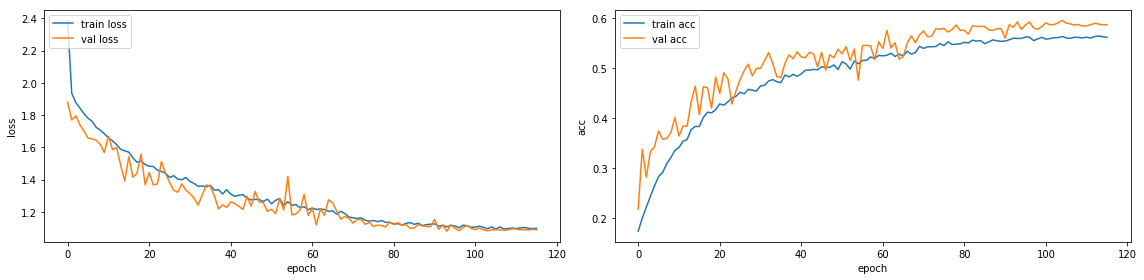

In [24]:
cp_name = './models/1st place/widthheightshiftrotatezoom_bn_seed1_lrinitial0.01_classweight.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , class_weight=class_weight
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45, zoom_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom, batch_norm, seed=1, lrinitial0.01, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}


c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (50498, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (50498, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 13s - loss: 2.1763 - acc: 0.2078 - val_loss: 1.8835 - val_acc: 0.2263
Epoch 2/500
197/197 [==============================] - 12s - loss: 1.8498 - acc: 0.2589 - val_loss: 1.7676 - val_acc: 0.3052
Epoch 3/500
197/197 [==============================] - 12s - loss: 1.7700 - acc: 0.3037 - val_loss: 1.6236 - val_acc: 0.3671
Epoch 4/500
197/197 [==============================] - 12s - loss: 1.7027 - acc: 0.3353 - val_loss: 1.5238 - val_acc: 0.4273
Epoch 5/500
197/197 [==============================] - 12s - loss: 1.6444 - acc: 0.3643 - val_loss: 1.5209 - val_acc: 0.4200
Epoch 6/500
197/197 [==============================] - 12s - loss: 1.5847 - acc: 0.3925 - val_loss: 1.4813 - val_acc: 0.4317
Epoch 7/500
197/197 [==============================] - 12s - loss: 1.5426 - acc: 0.4091 - val_loss: 1.4599 - val_acc: 0.4426
Epoch 8/500
197/197 [==============================] - 12s - loss: 1.5054 - acc: 0.4241 - val_loss:

197/197 [==============================] - 12s - loss: 1.1852 - acc: 0.5543 - val_loss: 1.3024 - val_acc: 0.5209
Epoch 27/500
197/197 [==============================] - 12s - loss: 1.1818 - acc: 0.5559 - val_loss: 1.1850 - val_acc: 0.5608
Epoch 28/500
197/197 [==============================] - 12s - loss: 1.1733 - acc: 0.5588 - val_loss: 1.1529 - val_acc: 0.5711
Epoch 29/500
197/197 [==============================] - 12s - loss: 1.1603 - acc: 0.5640 - val_loss: 1.2047 - val_acc: 0.5452
Epoch 30/500
197/197 [==============================] - 12s - loss: 1.1555 - acc: 0.5637 - val_loss: 1.1653 - val_acc: 0.5658
Epoch 31/500
197/197 [==============================] - 12s - loss: 1.1426 - acc: 0.5704 - val_loss: 1.1911 - val_acc: 0.5649
Epoch 32/500
197/197 [==============================] - 12s - loss: 1.1376 - acc: 0.5733 - val_loss: 1.1880 - val_acc: 0.5608
Epoch 33/500
197/197 [==============================] - 12s - loss: 1.1408 - acc: 0.5700 - val_loss: 1.1354 - val_acc: 0.5778
Epoch

197/197 [==============================] - 12s - loss: 0.9765 - acc: 0.6319 - val_loss: 1.0584 - val_acc: 0.6182
Epoch 88/500
196/197 [============================>.] - ETA: 0s - loss: 0.9877 - acc: 0.6285Epoch 00087: val_loss did not improve

Epoch 00087: reducing learning rate to 0.00015624999650754035.
197/197 [==============================] - 12s - loss: 0.9879 - acc: 0.6284 - val_loss: 1.0635 - val_acc: 0.6109
Epoch 89/500
197/197 [==============================] - 12s - loss: 0.9806 - acc: 0.6324 - val_loss: 1.0569 - val_acc: 0.6157
Epoch 90/500
197/197 [==============================] - 12s - loss: 0.9856 - acc: 0.6288 - val_loss: 1.0601 - val_acc: 0.6137
Epoch 91/500
197/197 [==============================] - 12s - loss: 0.9842 - acc: 0.6319 - val_loss: 1.0572 - val_acc: 0.6154
Epoch 92/500
197/197 [==============================] - 12s - loss: 0.9775 - acc: 0.6360 - val_loss: 1.0535 - val_acc: 0.6140
Epoch 93/500
196/197 [============================>.] - ETA: 0s - loss: 0.98

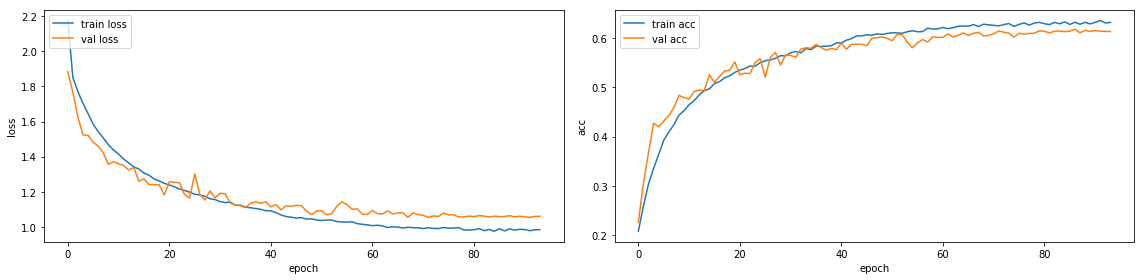

In [68]:
cp_name = './models/1st place/widthheightshiftrotatezoom_bn_seed1_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45, zoom_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear, batch_norm, seed=1, lrinitial0.01, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}


c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (50498, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (50498, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 13s - loss: 2.2290 - acc: 0.2077 - val_loss: 1.8558 - val_acc: 0.2628
Epoch 2/500
197/197 [==============================] - 12s - loss: 1.8387 - acc: 0.2663 - val_loss: 1.7445 - val_acc: 0.3105
Epoch 3/500
197/197 [==============================] - 12s - loss: 1.7640 - acc: 0.3063 - val_loss: 1.6183 - val_acc: 0.3779
Epoch 4/500
197/197 [==============================] - 12s - loss: 1.7073 - acc: 0.3342 - val_loss: 1.5959 - val_acc: 0.3997
Epoch 5/500
197/197 [==============================] - 12s - loss: 1.6490 - acc: 0.3624 - val_loss: 1.5058 - val_acc: 0.4222
Epoch 6/500
197/197 [==============================] - 12s - loss: 1.5939 - acc: 0.3876 - val_loss: 1.4619 - val_acc: 0.4454
Epoch 7/500
197/197 [==============================] - 12s - loss: 1.5523 - acc: 0.4032 - val_loss: 1.4694 - val_acc: 0.4443
Epoch 8/500
197/197 [==============================] - 12s - loss: 1.5111 - acc: 0.4233 - val_loss:

197/197 [==============================] - 12s - loss: 1.0834 - acc: 0.5924 - val_loss: 1.1399 - val_acc: 0.5727
Epoch 57/500
197/197 [==============================] - 12s - loss: 1.0883 - acc: 0.5892 - val_loss: 1.1046 - val_acc: 0.5805
Epoch 58/500
197/197 [==============================] - 12s - loss: 1.0772 - acc: 0.5920 - val_loss: 1.1005 - val_acc: 0.5889
Epoch 59/500
196/197 [============================>.] - ETA: 0s - loss: 1.0816 - acc: 0.5941Epoch 00058: val_loss did not improve

Epoch 00058: reducing learning rate to 0.0012499999720603228.
197/197 [==============================] - 12s - loss: 1.0815 - acc: 0.5940 - val_loss: 1.0877 - val_acc: 0.5847
Epoch 60/500
197/197 [==============================] - 12s - loss: 1.0742 - acc: 0.5958 - val_loss: 1.0899 - val_acc: 0.5934
Epoch 61/500
197/197 [==============================] - 12s - loss: 1.0700 - acc: 0.5978 - val_loss: 1.0879 - val_acc: 0.5886
Epoch 62/500
197/197 [==============================] - 12s - loss: 1.0707 - 

197/197 [==============================] - 12s - loss: 1.0530 - acc: 0.6035 - val_loss: 1.0763 - val_acc: 0.5953
Epoch 88/500
197/197 [==============================] - 12s - loss: 1.0567 - acc: 0.6011 - val_loss: 1.0604 - val_acc: 0.6017
Epoch 89/500
197/197 [==============================] - 12s - loss: 1.0510 - acc: 0.6052 - val_loss: 1.0741 - val_acc: 0.5939
Epoch 90/500
197/197 [==============================] - 12s - loss: 1.0500 - acc: 0.6032 - val_loss: 1.0797 - val_acc: 0.5923
Epoch 91/500
197/197 [==============================] - 12s - loss: 1.0490 - acc: 0.6041 - val_loss: 1.0658 - val_acc: 0.5987
Epoch 92/500
197/197 [==============================] - 12s - loss: 1.0476 - acc: 0.6044 - val_loss: 1.0629 - val_acc: 0.6034
Epoch 93/500
197/197 [==============================] - 12s - loss: 1.0529 - acc: 0.6027 - val_loss: 1.0912 - val_acc: 0.5892
Epoch 94/500
196/197 [============================>.] - ETA: 0s - loss: 1.0531 - acc: 0.6042Epoch 00093: val_loss did not improve



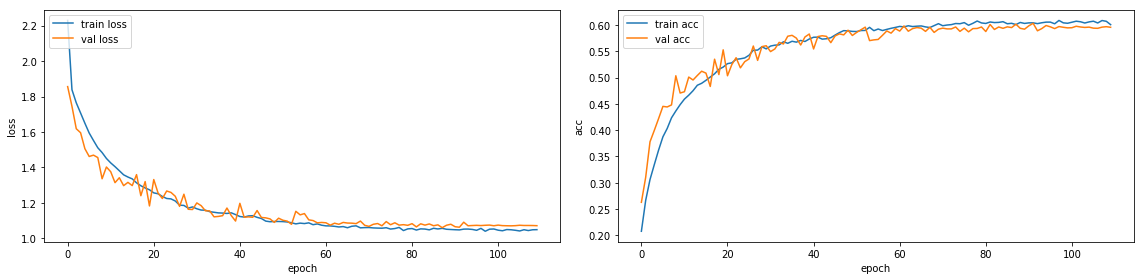

In [69]:
cp_name = './models/1st place/widthheightshiftrotatezoomshear_bn_seed1_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear,hist_equal, batch_norm, seed=1, lrinitial0.01, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 25s - loss: 13.6339 - acc: 0.1431 - val_loss: 13.1847 - val_acc: 0.1820
Epoch 2/500
197/197 [==============================] - 23s - loss: 13.8179 - acc: 0.1427 - val_loss: 13.1847 - val_acc: 0.1820
Epoch 3/500
197/197 [==============================] - 24s - loss: 13.8191 - acc: 0.1426 - val_loss: 13.1847 - val_acc: 0.1820
Epoch 4/500
197/197 [==============================] - 24s - loss: 13.8170 - acc: 0.1428 - val_loss: 13.1847 - val_acc: 0.1820
Epoch 5/500
197/197 [==============================] - 24s - loss: 13.8156 - acc: 0.1428 - val_loss: 13.1847 - val_acc: 0.1820
Epoch 6/500
197/197 [==============================] - 24s - loss: 13.8186 - acc: 0.1427 - val_loss: 13.1847 - val_acc: 0.182

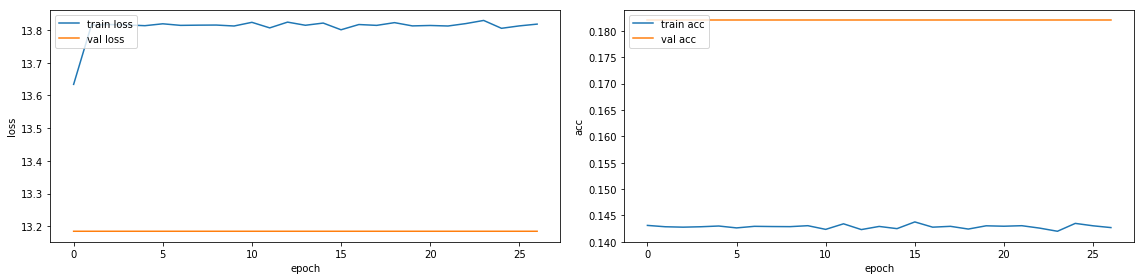

In [80]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearhistequal_bn_seed1_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear,hist_equal, batch_norm, seed=1, lrinitial0.001, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.001
Epoch 1/500
197/197 [==============================] - 25s - loss: 2.1025 - acc: 0.1409 - val_loss: 3.4910 - val_acc: 0.1134
Epoch 2/500
197/197 [==============================] - 24s - loss: 2.0240 - acc: 0.1445 - val_loss: 7.6244 - val_acc: 0.0641
Epoch 3/500
197/197 [==============================] - 24s - loss: 2.0017 - acc: 0.1446 - val_loss: 8.3889 - val_acc: 0.0622
Epoch 4/500
197/197 [==============================] - 24s - loss: 1.9877 - acc: 0.1448 - val_loss: 8.7082 - val_acc: 0.0647
Epoch 5/500
197/197 [==============================] - 24s - loss: 1.9762 - acc: 0.1553 - val_loss: 7.4925 - val_acc: 0.1324
Epoch 6/500
197/197 [==============================] - 24s - loss: 1.9722 - acc: 0.1541 - val_loss: 6.3013 - val_acc: 0.1357
Epoch 7/5

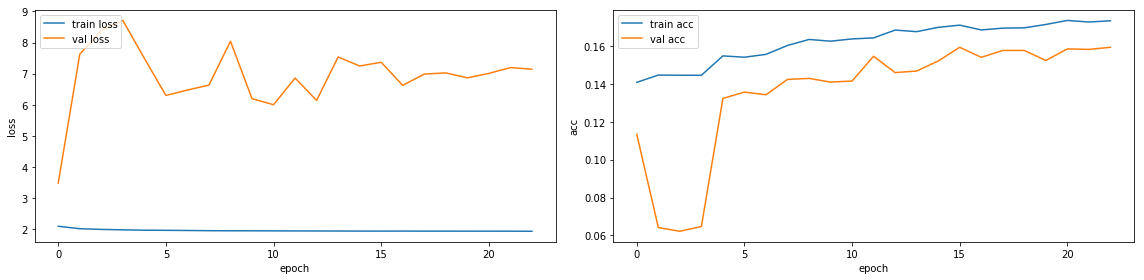

In [85]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearhistequal_bn_seed1_lrinitial0.001_oversample.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.001, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear,hist_equal, batch_norm, seed=1, lrinitial0.0001, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.0001
Epoch 1/500
197/197 [==============================] - 25s - loss: 2.1785 - acc: 0.1441 - val_loss: 5.7836 - val_acc: 0.1363
Epoch 2/500
197/197 [==============================] - 23s - loss: 2.1140 - acc: 0.1432 - val_loss: 12.5735 - val_acc: 0.0833
Epoch 3/500
197/197 [==============================] - 24s - loss: 2.0932 - acc: 0.1434 - val_loss: 14.1583 - val_acc: 0.0315
Epoch 4/500
197/197 [==============================] - 24s - loss: 2.0817 - acc: 0.1426 - val_loss: 14.5295 - val_acc: 0.0240
Epoch 5/500
197/197 [==============================] - 24s - loss: 2.0668 - acc: 0.1441 - val_loss: 14.3029 - val_acc: 0.0262
Epoch 6/500
197/197 [==============================] - 24s - loss: 2.0577 - acc: 0.1435 - val_loss: 14.2257 - val_acc: 0.0245
Epo

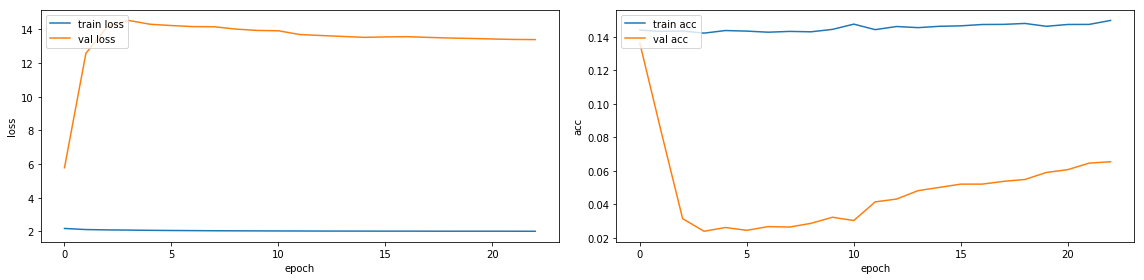

In [86]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearhistequal_bn_seed1_lrinitial0.0001_oversample.hdf5'

# build model
model = helper.build_model('1st_place', batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.0001, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)


## featurewise, flip, width_shift, height_shift, rotate, zoom,shear,hist_equal, batch_norm, seed=2, lrinitial0.0001, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.0001
Epoch 1/500
197/197 [==============================] - 25s - loss: 2.2064 - acc: 0.1417 - val_loss: 4.2828 - val_acc: 0.2511
Epoch 2/500
197/197 [==============================] - 24s - loss: 2.1361 - acc: 0.1440 - val_loss: 9.4847 - val_acc: 0.2506
Epoch 3/500
197/197 [==============================] - 24s - loss: 2.1073 - acc: 0.1441 - val_loss: 10.9943 - val_acc: 0.2494
Epoch 4/500
197/197 [==============================] - 24s - loss: 2.0933 - acc: 0.1448 - val_loss: 11.1564 - val_acc: 0.2503
Epoch 5/500
197/197 [==============================] - 24s - loss: 2.0798 - acc: 0.1437 - val_loss: 10.9590 - val_acc: 0.2475
Epoch 6/500
197/197 [==============================] - 24s - loss: 2.0704 - acc: 0.1421 - val_loss: 10.8838 - val_acc: 0.2453
Epoc

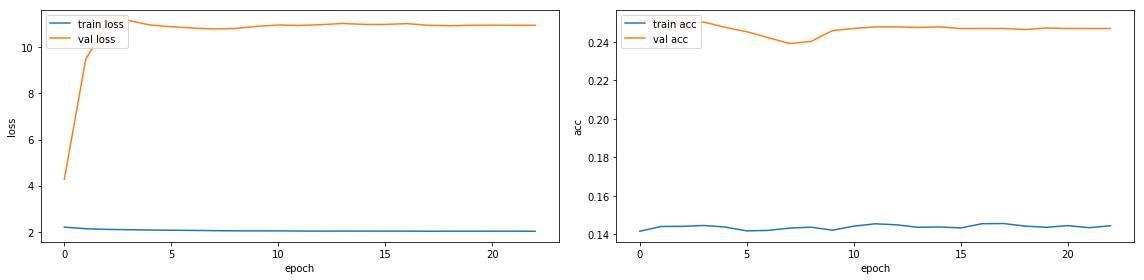

In [87]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearhistequal_bn_seed2_lrinitial0.0001_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.0001, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)


## featurewise, flip, width_shift, height_shift, rotate, zoom,shear,hist_equal, batch_norm, seed=2, lrinitial0.1, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.1
Epoch 1/500
197/197 [==============================] - 26s - loss: 13.7533 - acc: 0.1429 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 2/500
197/197 [==============================] - 23s - loss: 13.8142 - acc: 0.1429 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 3/500
197/197 [==============================] - 24s - loss: 13.8168 - acc: 0.1428 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 4/500
197/197 [==============================] - 24s - loss: 13.8133 - acc: 0.1430 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 5/500
197/197 [==============================] - 24s - loss: 13.8067 - acc: 0.1434 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 6/500
197/197 [==============================] - 24s - loss: 13.8249 - acc: 0.1423 - val_loss: 14.0247 - val_acc: 0.1299

197/197 [==============================] - 24s - loss: 13.8214 - acc: 0.1425 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 31/500
197/197 [==============================] - 24s - loss: 13.8115 - acc: 0.1431 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 32/500
196/197 [============================>.] - ETA: 0s - loss: 13.8343 - acc: 0.1417Epoch 00031: val_loss did not improve

Epoch 00031: reducing learning rate to 0.0015625000232830644.
197/197 [==============================] - 24s - loss: 13.8332 - acc: 0.1418 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 33/500
197/197 [==============================] - 24s - loss: 13.7967 - acc: 0.1440 - val_loss: 14.0247 - val_acc: 0.1299
Epoch 34/500
197/197 [==============================] - 24s - loss: 13.8113 - acc: 0.1431 - val_loss: 14.0247 - val_acc: 0.1299
private test metrics [13.915402187806341, 0.13665964843899225]


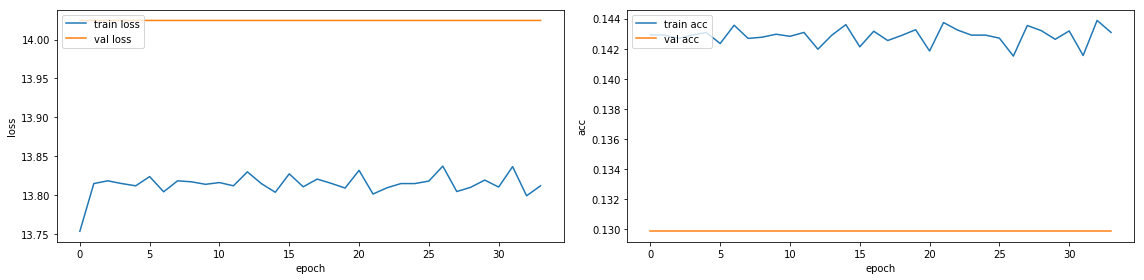

In [106]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearhistequal_bn_seed2_lrinitial0.1_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear, batch_norm, see lrinitial0.0001, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.0001
Epoch 1/500
197/197 [==============================] - 14s - loss: 2.4195 - acc: 0.1577 - val_loss: 1.9298 - val_acc: 0.2079
Epoch 2/500
197/197 [==============================] - 12s - loss: 2.2555 - acc: 0.1742 - val_loss: 1.9356 - val_acc: 0.2196
Epoch 3/500
197/197 [==============================] - 12s - loss: 2.1914 - acc: 0.1850 - val_loss: 1.9281 - val_acc: 0.2288
Epoch 4/500
197/197 [==============================] - 12s - loss: 2.1504 - acc: 0.1907 - val_loss: 1.9136 - val_acc: 0.2539
Epoch 5/500
197/197 [==============================] - 12s - loss: 2.1261 - acc: 0.1978 - val_loss: 1.8858 - val_acc: 0.2550
Epoch 6/500
197/197 [==============================] - 12s - loss: 2.0955 - acc: 0.2081 - val_loss: 1.9018 - val_acc: 0.2461
Epoch 7/

197/197 [==============================] - 12s - loss: 1.8465 - acc: 0.2825 - val_loss: 1.6565 - val_acc: 0.3671
Epoch 28/500
197/197 [==============================] - 12s - loss: 1.8383 - acc: 0.2843 - val_loss: 1.6610 - val_acc: 0.3645
Epoch 29/500
197/197 [==============================] - 12s - loss: 1.8356 - acc: 0.2872 - val_loss: 1.6807 - val_acc: 0.3554
Epoch 30/500
197/197 [==============================] - 12s - loss: 1.8278 - acc: 0.2900 - val_loss: 1.6553 - val_acc: 0.3620
Epoch 31/500
197/197 [==============================] - 12s - loss: 1.8194 - acc: 0.2939 - val_loss: 1.6468 - val_acc: 0.3710
Epoch 32/500
197/197 [==============================] - 12s - loss: 1.8200 - acc: 0.2908 - val_loss: 1.6602 - val_acc: 0.3693
Epoch 33/500
197/197 [==============================] - 12s - loss: 1.8141 - acc: 0.2950 - val_loss: 1.6503 - val_acc: 0.3685
Epoch 34/500
197/197 [==============================] - 12s - loss: 1.8096 - acc: 0.2964 - val_loss: 1.6334 - val_acc: 0.3821
Epoch

197/197 [==============================] - 12s - loss: 1.6462 - acc: 0.3682 - val_loss: 1.4818 - val_acc: 0.4454
Epoch 85/500
197/197 [==============================] - 12s - loss: 1.6390 - acc: 0.3703 - val_loss: 1.4877 - val_acc: 0.4423
Epoch 86/500
197/197 [==============================] - 12s - loss: 1.6412 - acc: 0.3711 - val_loss: 1.4801 - val_acc: 0.4420
Epoch 87/500
197/197 [==============================] - 12s - loss: 1.6378 - acc: 0.3725 - val_loss: 1.4791 - val_acc: 0.4373
Epoch 88/500
197/197 [==============================] - 12s - loss: 1.6398 - acc: 0.3712 - val_loss: 1.4629 - val_acc: 0.4518
Epoch 89/500
197/197 [==============================] - 12s - loss: 1.6378 - acc: 0.3713 - val_loss: 1.4880 - val_acc: 0.4406
Epoch 90/500
197/197 [==============================] - 12s - loss: 1.6320 - acc: 0.3737 - val_loss: 1.4988 - val_acc: 0.4365
Epoch 91/500
197/197 [==============================] - 12s - loss: 1.6302 - acc: 0.3740 - val_loss: 1.4575 - val_acc: 0.4504
Epoch

197/197 [==============================] - 12s - loss: 1.5980 - acc: 0.3875 - val_loss: 1.4369 - val_acc: 0.4629
Epoch 146/500
197/197 [==============================] - 12s - loss: 1.5965 - acc: 0.3894 - val_loss: 1.4371 - val_acc: 0.4624
Epoch 147/500
196/197 [============================>.] - ETA: 0s - loss: 1.5924 - acc: 0.3901Epoch 00146: val_loss did not improve

Epoch 00146: reducing learning rate to 3.906249901319825e-07.
197/197 [==============================] - 12s - loss: 1.5927 - acc: 0.3900 - val_loss: 1.4370 - val_acc: 0.4629
Epoch 148/500
197/197 [==============================] - 12s - loss: 1.5996 - acc: 0.3888 - val_loss: 1.4367 - val_acc: 0.4632
private test metrics [1.4101730458999358, 0.47276763128023913]


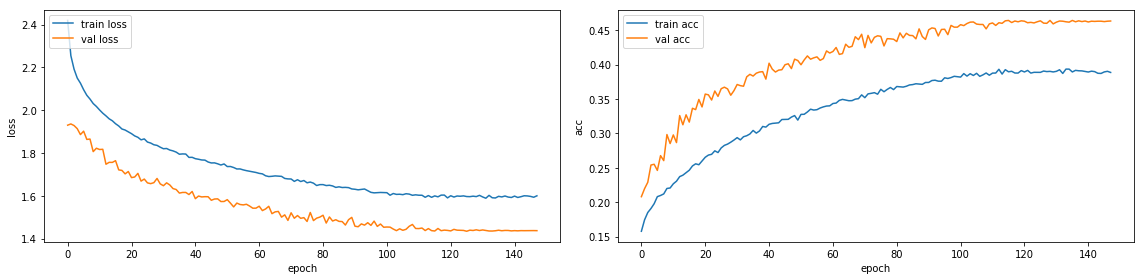

In [88]:
cp_name = './models/1st place/widthheightshiftrotatezoomshear_bn_seed2_lrinitial0.0001_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.0001, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear, batch_norm, seed=2, lrinitial0.01, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 16s - loss: 2.1182 - acc: 0.2123 - val_loss: 1.8824 - val_acc: 0.1996
Epoch 2/500
197/197 [==============================] - 12s - loss: 1.8314 - acc: 0.2693 - val_loss: 1.7420 - val_acc: 0.3105
Epoch 3/500
197/197 [==============================] - 12s - loss: 1.7578 - acc: 0.3098 - val_loss: 1.6100 - val_acc: 0.3807
Epoch 4/500
197/197 [==============================] - 12s - loss: 1.6954 - acc: 0.3401 - val_loss: 1.6835 - val_acc: 0.3367
Epoch 5/500
197/197 [==============================] - 12s - loss: 1.6436 - acc: 0.3665 - val_loss: 1.4680 - val_acc: 0.4412
Epoch 6/500
197/197 [==============================] - 12s - loss: 1.5937 - acc: 0.3888 - val_loss: 1.4518 - val_acc: 0.4599
Epoch 7/50

197/197 [==============================] - 12s - loss: 1.0515 - acc: 0.6019 - val_loss: 1.1100 - val_acc: 0.5878
Epoch 58/500
197/197 [==============================] - 12s - loss: 1.0397 - acc: 0.6070 - val_loss: 1.1552 - val_acc: 0.5691
Epoch 59/500
197/197 [==============================] - 12s - loss: 1.0396 - acc: 0.6099 - val_loss: 1.0875 - val_acc: 0.5939
Epoch 60/500
197/197 [==============================] - 12s - loss: 1.0413 - acc: 0.6077 - val_loss: 1.0965 - val_acc: 0.5897
Epoch 61/500
197/197 [==============================] - 12s - loss: 1.0333 - acc: 0.6107 - val_loss: 1.0977 - val_acc: 0.5962
Epoch 62/500
197/197 [==============================] - 12s - loss: 1.0378 - acc: 0.6092 - val_loss: 1.0908 - val_acc: 0.5886
Epoch 63/500
197/197 [==============================] - 12s - loss: 1.0311 - acc: 0.6121 - val_loss: 1.1203 - val_acc: 0.5836
Epoch 64/500
197/197 [==============================] - 12s - loss: 1.0252 - acc: 0.6130 - val_loss: 1.1167 - val_acc: 0.5836
Epoch

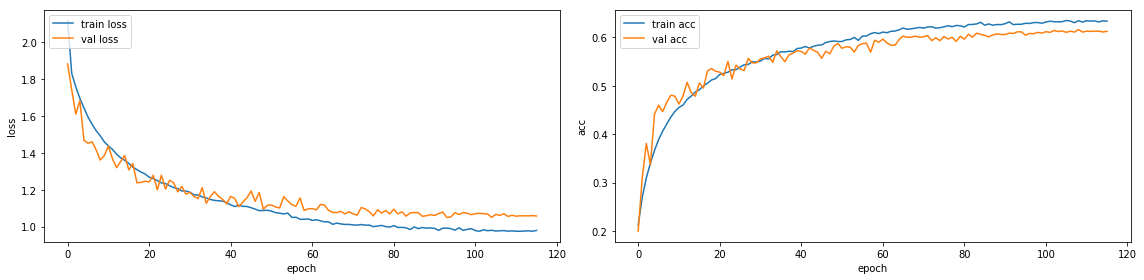

In [89]:
cp_name = './models/1st place/widthheightshiftrotatezoomshear_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear, hist_equal_custom, batch_norm, seed=2, lrinitial0.01, over_sample

In [104]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearhistequalcust_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=hist_equal)


# visualize metrics
helper.visualize_metrics(history)

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.01
Epoch 1/500


Exception in thread Thread-32:
Traceback (most recent call last):
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\utils\data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 737, in __next__
    return self.next(*args, **kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 815, in next
    x = self.image_data_generator.standardize(x)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\sit

StopIteration: 

## featurewise, flip, width_shift, height_shift, rotate, zoom,shear, adapt_histequal, batch_norm, seed=2, lrinitial0.01, over_sample

In [114]:
cp_name = './models/1st place/widthheightshiftrotatezoomshearadapthistequal_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                      , width_shift_range=0.2, height_shift_range=0.2, rotation_range=.45
                       , zoom_range=0.2, shear_range=0.2, preprocessing_function=adapthist_equal)


# visualize metrics
helper.visualize_metrics(history)

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
Start learning rate: 0.01
Epoch 1/500


Exception in thread Thread-35:
Traceback (most recent call last):
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\utils\data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 737, in __next__
    return self.next(*args, **kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 815, in next
    x = self.image_data_generator.standardize(x)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\sit

StopIteration: 

## featurewise, flip, histequal to test, batch_norm, seed=1, lrinitial0.01, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
passed preprocessing_function <function equalize_hist at 0x000001DBEBF45B70>
Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 19s - loss: 11.7153 - acc: 0.1443 - val_loss: 11.3109 - val_acc: 0.1297
Epoch 2/500
197/197 [==============================] - 16s - loss: 11.7204 - acc: 0.1433 - val_loss: 11.3084 - val_acc: 0.1285
Epoch 3/500
197/197 [==============================] - 16s - loss: 11.7209 - acc: 0.1424 - val_loss: 11.2784 - val_acc: 0.1822
Epoch 4/500
197/197 [==============================] - 16s - loss: 11.7148 - acc: 0.1431 - val_loss: 11.3031 - val_acc: 0.1321
Epoch 5/500
197/197 [==============================] - 16s - loss: 11.7061 - acc: 0.1450 - val_loss: 11.3460 - val_acc: 0.1789
Epoch 6/500
197/197 [===========================

197/197 [==============================] - 16s - loss: 1.9462 - acc: 0.1429 - val_loss: 1.9475 - val_acc: 0.0159
Epoch 30/500
197/197 [==============================] - 16s - loss: 1.9463 - acc: 0.1412 - val_loss: 1.9473 - val_acc: 0.0159
Epoch 31/500
197/197 [==============================] - 16s - loss: 1.9462 - acc: 0.1435 - val_loss: 1.9470 - val_acc: 0.0153
Epoch 32/500
197/197 [==============================] - 16s - loss: 1.9463 - acc: 0.1429 - val_loss: 1.9468 - val_acc: 0.0153
Epoch 33/500
197/197 [==============================] - 16s - loss: 1.9461 - acc: 0.1439 - val_loss: 1.9467 - val_acc: 0.1297
Epoch 34/500
196/197 [============================>.] - ETA: 0s - loss: 1.9462 - acc: 0.1427Epoch 00033: val_loss did not improve

Epoch 00033: reducing learning rate to 0.0006249999860301614.
197/197 [==============================] - 16s - loss: 1.9462 - acc: 0.1429 - val_loss: 1.9472 - val_acc: 0.0153
Epoch 35/500
197/197 [==============================] - 16s - loss: 1.9462 - 

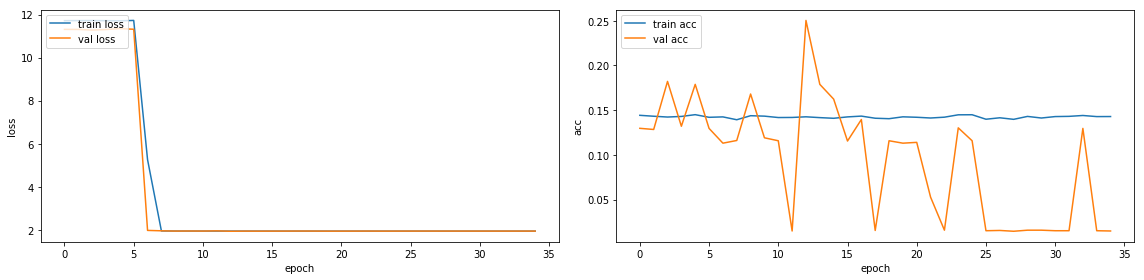

In [129]:
cp_name = './models/1st place/histequaltotest_bn_seed1_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=1), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, histequal to test, batch_norm, seed=2, lrinitial0.01, over_sample

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
passed preprocessing_function <function equalize_hist at 0x000001DBEBF45B70>
Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 19s - loss: 11.7060 - acc: 0.1444 - val_loss: 9.6549 - val_acc: 0.2494
Epoch 2/500
197/197 [==============================] - 16s - loss: 11.7175 - acc: 0.1426 - val_loss: 9.6665 - val_acc: 0.2476
Epoch 3/500
197/197 [==============================] - 16s - loss: 9.9514 - acc: 0.1453 - val_loss: 1.8841 - val_acc: 0.2467
Epoch 4/500
197/197 [==============================] - 16s - loss: 1.9593 - acc: 0.1435 - val_loss: 1.9603 - val_acc: 0.1321
Epoch 5/500
197/197 [==============================] - 16s - loss: 1.9518 - acc: 0.1421 - val_loss: 1.9485 - val_acc: 0.1393
Epoch 6/500
197/197 [==============================] - 1

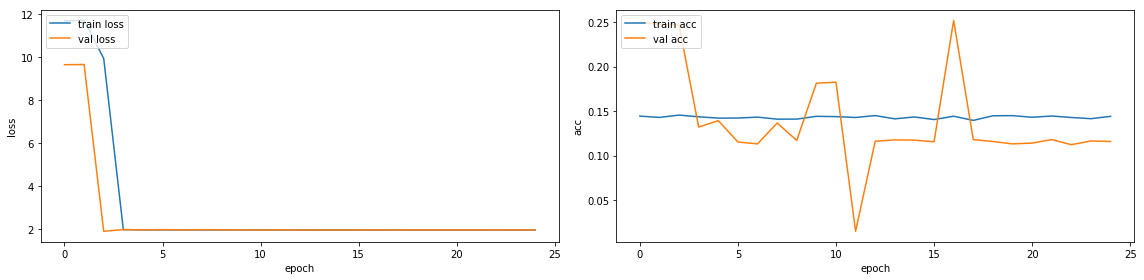

In [132]:
cp_name = './models/1st place/histequaltotest_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, histequal to test, batch_norm, seed=2, lrinitial0.01, over_sample

In [119]:
cp_name = './models/1st place/histequaltotest_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , preprocessing_function=exposure.equalize_hist)


# visualize metrics
helper.visualize_metrics(history)

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
passed preprocessing_function <function equalize_hist at 0x000001DBEBF45B70>
Start learning rate: 0.01
Epoch 1/500
197/197 [==============================] - 17s - loss: 11.7052 - acc: 0.1445 - val_loss: 10.5421 - val_acc: 0.1686
Epoch 2/500
197/197 [==============================] - 15s - loss: 11.7173 - acc: 0.1425 - val_loss: 10.4432 - val_acc: 0.1664
Epoch 3/500
197/197 [==============================] - 15s - loss: 11.7084 - acc: 0.1457 - val_loss: 10.8036 - val_acc: 0.1681
Epoch 4/500
197/197 [==============================] - 15s - loss: 7.8802 - acc: 0.1417 - val_loss: 10.7273 - val_acc: 0.1692
Epoch 5/500
197/197 [==============================] - 15s - loss: 1.9567 - acc: 0.1433 - val_loss: 10.0713 - val_acc: 0.1683
Epoch 6/500
197/197 [=============================

KeyboardInterrupt: 

## featurewise, flip, custom adapthistequal to test, batch_norm, seed=2, lrinitial0.01, over_sample

In [121]:
cp_name = './models/1st place/customadapthistequaltotest_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , preprocessing_function=adapthist_equal)


# visualize metrics
helper.visualize_metrics(history)

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
passed preprocessing_function <function adapthist_equal at 0x000001DA7D8269D8>
Start learning rate: 0.01
Epoch 1/500


Exception in thread Thread-38:
Traceback (most recent call last):
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\utils\data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 737, in __next__
    return self.next(*args, **kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 815, in next
    x = self.image_data_generator.standardize(x)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\sit

StopIteration: 

## featurewise, flip, adapthistequal to test, batch_norm, seed=2, lrinitial0.01, over_sample

In [128]:
cp_name = './models/1st place/adapthistequaltotest_bn_seed2_lrinitial0.01_oversample.hdf5'

# build model
model = helper.build_model('1st_place', kernel_initializer=TruncatedNormal(seed=2), batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, model, cp_name
                       , lr_initial=0.01, lr_min=1e-07
                       , preprocessing_function=exposure.equalize_adapthist)


# visualize metrics
helper.visualize_metrics(history)

training distribution before over sample: 
 {0: 3988, 1: 436, 2: 4097, 3: 7214, 4: 4829, 5: 3170, 6: 4964}
training distribution after over sample: 
 {0: 7214, 1: 7214, 2: 7214, 3: 7214, 4: 7214, 5: 7214, 6: 7214}
passed preprocessing_function <function equalize_adapthist at 0x000001DBDA8D4950>
Start learning rate: 0.01
Epoch 1/500


Exception in thread Thread-39:
Traceback (most recent call last):
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\utils\data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 737, in __next__
    return self.next(*args, **kwargs)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py", line 815, in next
    x = self.image_data_generator.standardize(x)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\sit

StopIteration: 

In [71]:
from skimage import exposure

In [120]:
def hist_equal(img):
    '''img is a numpy array of an image. 
    In this case, its shape is (48,48,1)'''
    return np.reshape(exposure.equalize_hist(np.reshape(img, (image_shape[0], image_shape[1])))
                      , (*image_shape))

def adapthist_equal(img):
    '''img is a numpy array of an image. 
    In this case, its shape is (48,48)'''
    return exposure.equalize_adapthist(np.reshape(img, (48,48)))

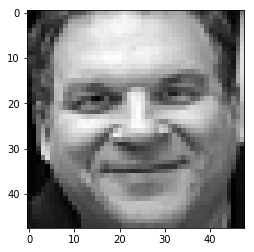

In [130]:
img_array = np.reshape(x_train[2], (48,48))
plt.imshow(img_array, cmap='gray')

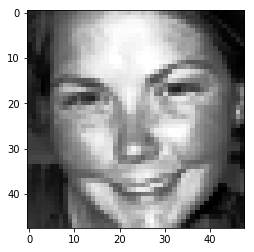

In [125]:
# t = exposure.equalize_hist(np.reshape(x_train[0], (48,48)))
t = exposure.equalize_hist(np.reshape(x_train[1], (image_shape[0],image_shape[1])))
img_array1 = np.reshape(t, (48,48))
plt.imshow(img_array1, cmap='gray')


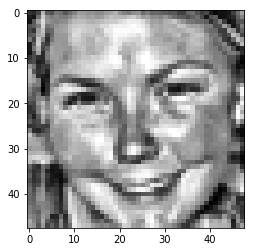

In [124]:
t = exposure.equalize_adapthist(np.reshape(x_train[1], (48,48)))
img_array = np.reshape(t, (48,48))
plt.imshow(img_array, cmap='gray')


In [107]:
keras.__version__

'2.0.6'

In [108]:
import tensorflow as tf
tf.__version__

'1.2.1'

In [110]:
x_train[0].shape

(48, 48, 1)

In [111]:
import cv2
equ = cv2.equalizeHist(np.reshape(x_train[0], (48,48)))
equ.shape

error: D:\Build\OpenCV\opencv-3.2.0\modules\imgproc\src\histogram.cpp:3808: error: (-215) _src.type() == CV_8UC1 in function cv::equalizeHist
